The existing dataset is only text snippets. We will feature engineer new variables to use and analyze.

In [1]:
pip install pandas nltk seaborn matplotlib numpy liwc scikit-learn empath

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import nltk
nltk.download('punkt') # Tokenization
nltk.download('vader_lexicon') # Sentiment Intensity Model

[nltk_data] Downloading package punkt to /home/chengyi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1]:
import pandas as pd

# Import data
df = pd.read_csv('dataset.csv')
df

Unnamed: 0.1  Unnamed: 0  \
0                 0           0   
1                 1           1   
2                 2           2   
3                 3           3   
4                 4           4   
...             ...         ...   
52676         52676       52676   
52677         52677       52677   
52678         52678       52678   
52679         52679       52679   
52680         52680       52680   

                                               statement   status  sia_neg  \
0                                             oh my gosh  anxiety    0.000   
1      trouble sleeping confused mind restless heart ...  anxiety    0.504   
2      all wrong back off dear forward doubt stay in ...  anxiety    0.480   
3      ive shifted my focus to something else but im ...  anxiety    0.219   
4      im restless and restless its been a month now ...  anxiety    0.276   
...                                                  ...      ...      ...   
52676  nobody takes me seriously ive 24m dealt with d...  anxiety    0.097   
52677  selfishness i dont feel very good its like i d...  anxiety    0.242   
52678  is there any way to sleep better i cant sleep ...  anxiety    0.118   
52679  public speaking tips hi all i have to give a p...  anxiety    0.137   
52680  i have really bad door anxiety its not about b...  anxiety    0.204   

       sia_neu  sia_pos  sia_compound  
0        1.000    0.000        0.0000  
1        0.496    0.000       -0.7269  
2        0.392    0.127       -0.7351  
3        0.781    0.000       -0.4215  
4        0.724    0.000       -0.4939  
...        ...      ...           ...  
52676    0.788    0.114       -0.0293  
52677    0.637    0.120       -0.9796  
52678    0.731    0.151        0.1635  
52679    0.800    0.063       -0.6115  
52680    0.682    0.113       -0.8498  

[52681 rows x 8 columns]

# Class distributions

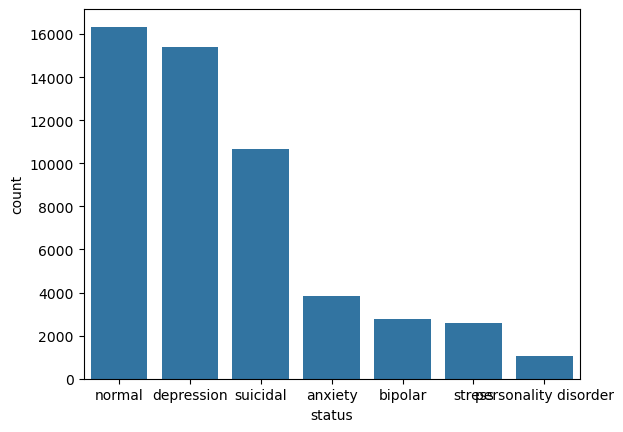

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution
sns.barplot(df['status'].value_counts())
plt.show()

In [ ]:
len(['' for status in df['status'] if status == 'personality disorder'])

1077

We will have to sample a random 1077 from every class except for personality disorder to create a balanced class distribution. This would leave us with 1077 * 7 = 7539 samples

# Sample length

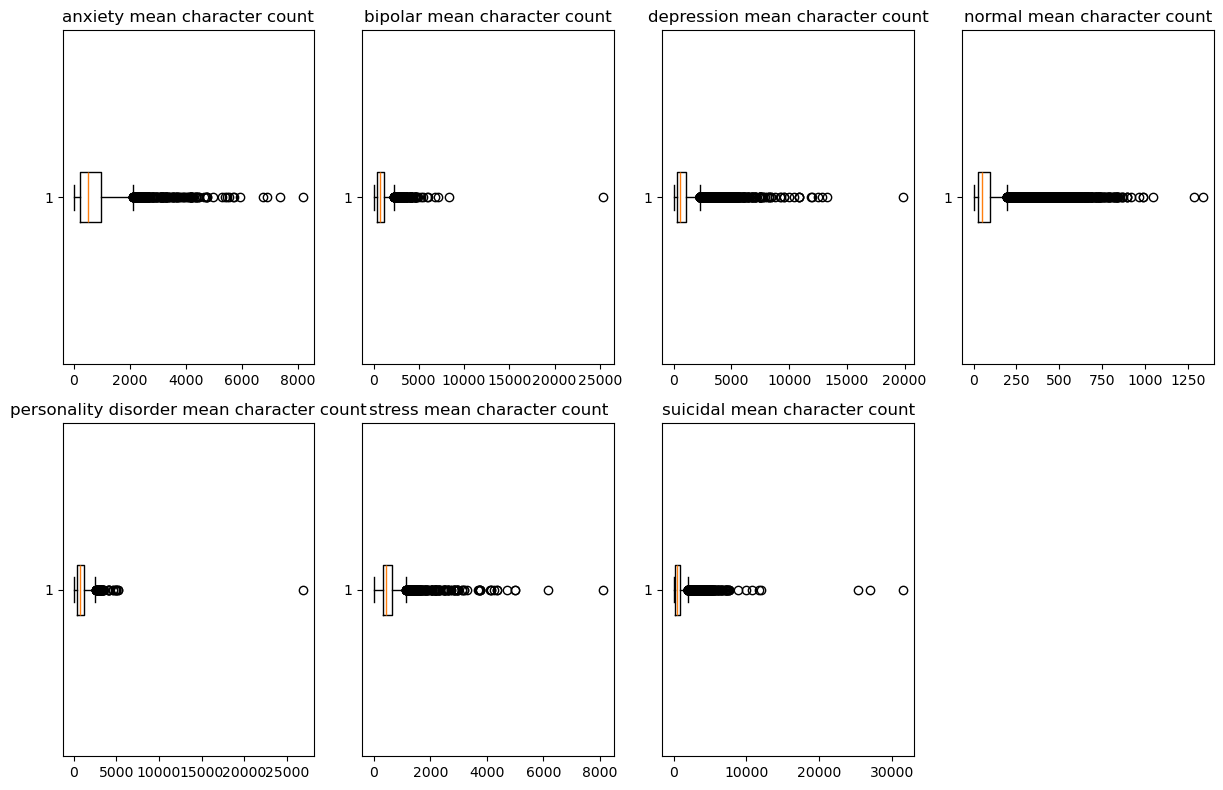

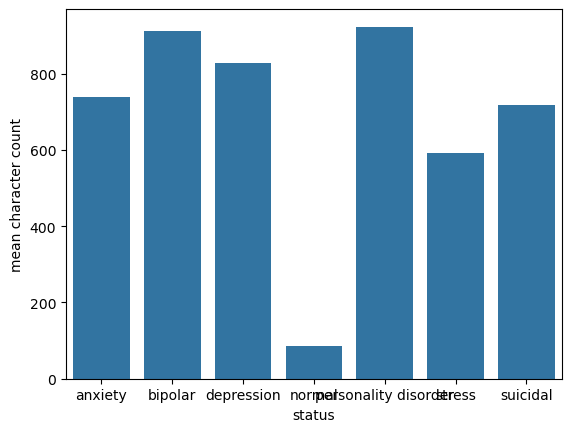

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Plot mean character count per class
plt.figure(figsize=(12, 8))
status2meanchar = {}
for i, (status, group_df) in enumerate(list(df.groupby('status')), 1):

    # Calculate stuff (I'm borrowing code from lec1-outlier.ipynb)
    group_df['character_count'] = group_df['statement'].str.len()
    status2meanchar[status] = group_df['character_count'].mean()
    q1 = np.percentile(group_df['character_count'], 25)
    q2 = np.percentile(group_df['character_count'], 50)
    q3 = np.percentile(group_df['character_count'], 75)
    iqr = q3 - q1
    min_value = q1 - 1.5 * iqr
    max_value = q3 + 1.5 * iqr
    plt.subplot(2, 4, i)
    plt.boxplot(group_df['character_count'], vert=False)
    plt.title(status + " mean character count")

plt.tight_layout()
plt.show()

sns.barplot(status2meanchar)
plt.xlabel('status')
plt.ylabel('mean character count')
plt.show()

In terms of character length, all of our classes are right-skewed.

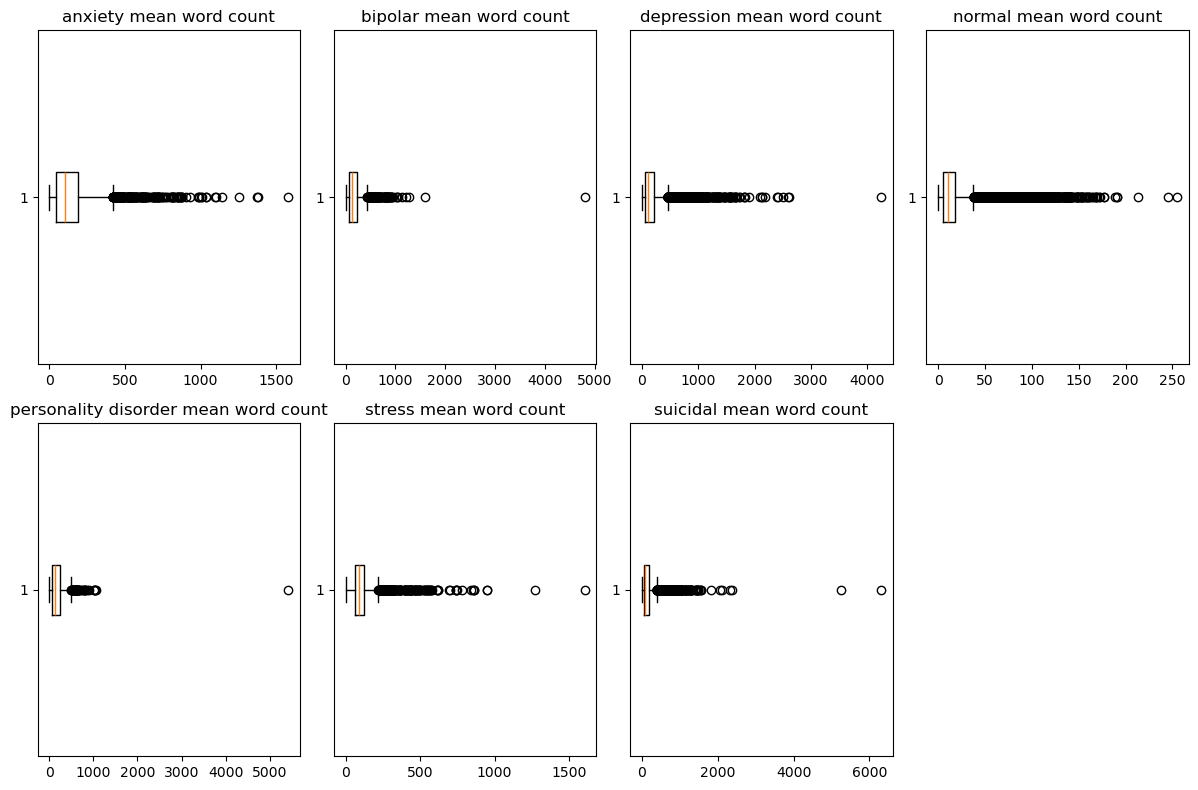

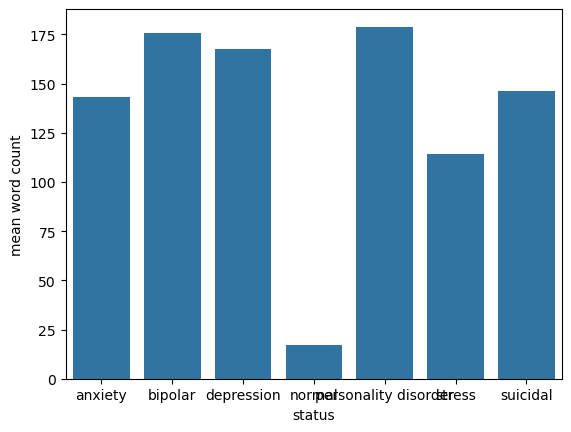

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Plot mean word count per class
plt.figure(figsize=(12, 8))
status2meanwords = {}
for i, (status, group_df) in enumerate(list(df.groupby('status')), 1):

    # Calculate stuff (I'm borrowing code from lec1-outlier.ipynb)
    group_df['word_count'] = group_df['statement'].str.split().str.len()
    status2meanwords[status] = group_df['word_count'].mean()
    q1 = np.percentile(group_df['word_count'], 25)
    q2 = np.percentile(group_df['word_count'], 50)
    q3 = np.percentile(group_df['word_count'], 75)
    iqr = q3 - q1
    min_value = q1 - 1.5 * iqr
    max_value = q3 + 1.5 * iqr
    plt.subplot(2, 4, i)
    plt.boxplot(group_df['word_count'], vert=False)
    plt.title(status + " mean word count")

plt.tight_layout()
plt.show()

sns.barplot(status2meanwords)
plt.xlabel('status')
plt.ylabel('mean word count')
plt.show()

Similarly, with word length, all of our classes are right-skewed.

Notes:
- From this, we won't use word/character length as a predictor if we want to assume that our input features follow a normal distribuiton (they simply don't)
- However, we're also naively looking at length without considering proportions that might be more informative. Right now we are looking at words/characters per sample, when we words/characters per sentence might show more clues as to what to look for.

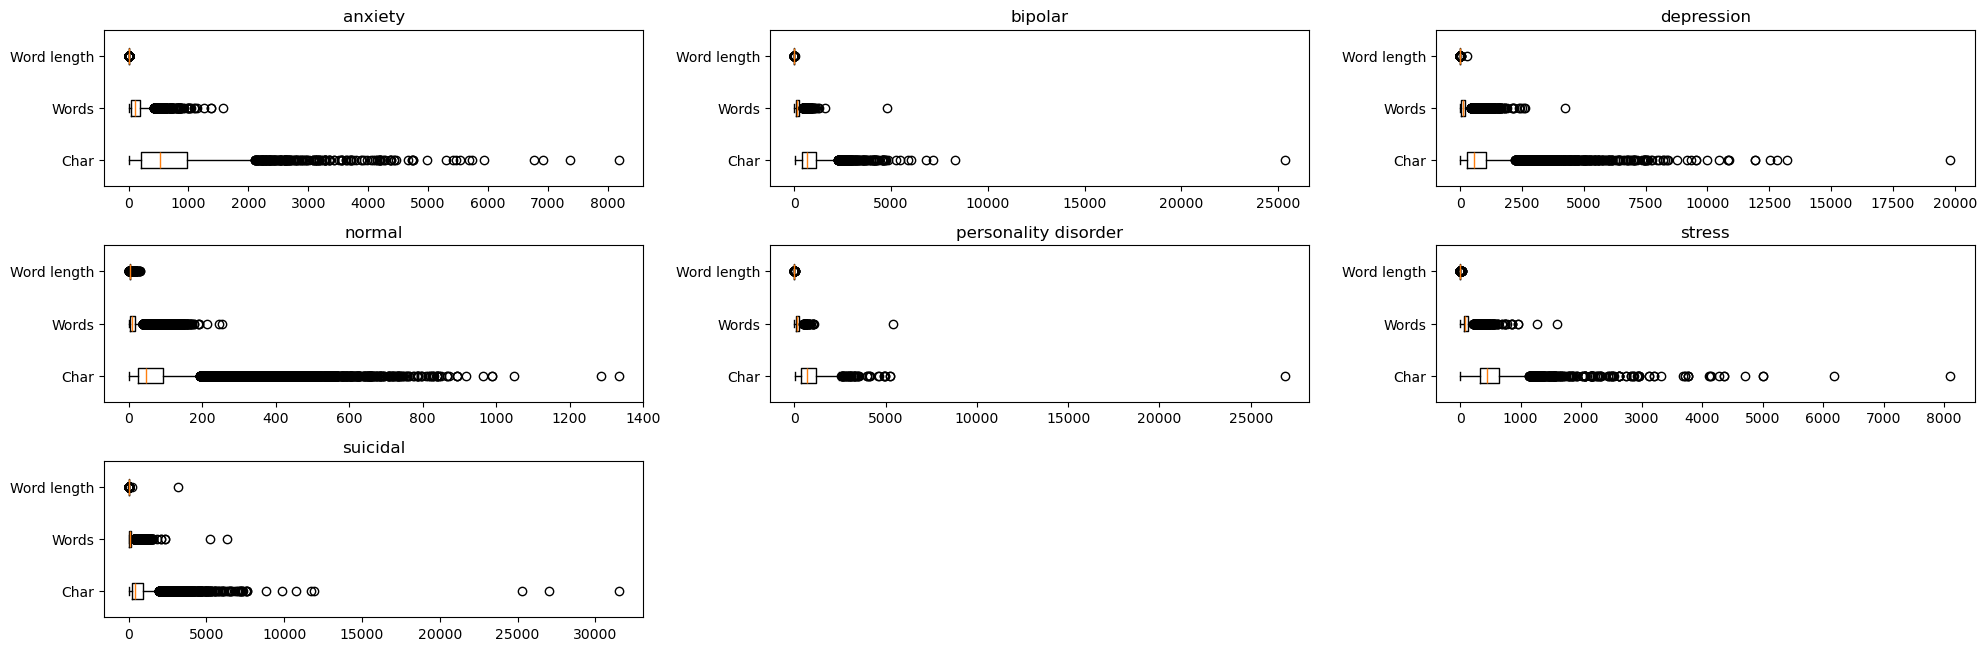

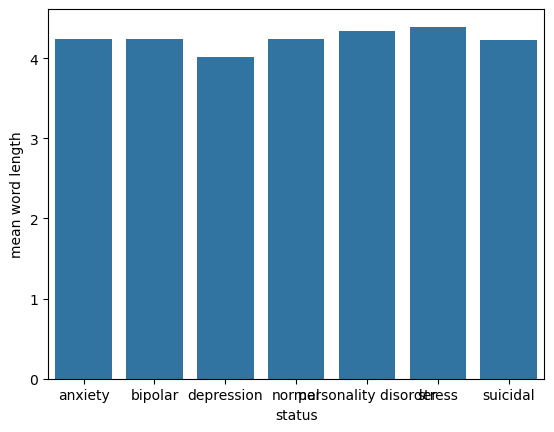

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize

# Plot mean word count per class
plt.figure(figsize=(20, 15))
status2wordlength = {}
for i, (status, group_df) in enumerate(list(df.groupby('status')), 1):

    # Calculate stuff (I'm borrowing code from lec1-outlier.ipynb)
    means = []
    for sample in group_df  ['statement']:
        sentences = sent_tokenize(sample)
        if sentences != []:
            lengths_characters = [len(sentence) for sentence in sentences] # Perhaps some classes use shorter sentences (in character length)
            lengths_words = [len(sentence.split()) for sentence in sentences] # Perhaps some classes use shorter sentences (in word length)
            lengths_word_character_length = [len(word) for sentence in sentences for word in sentence.split()] # Perhaps some classes use shorter words
            means.append({'character' : sum(lengths_characters)/len(lengths_characters), 'words': sum(lengths_words)/len(lengths_words), 'word_length' : sum(lengths_word_character_length)/len(lengths_word_character_length)})
        else:
            means.append({'character': 0, 'words': 0, 'word_length': 0})
    means_df = pd.DataFrame(means)
    status2wordlength[status] = means_df['word_length'].mean()
    plt.subplot(7, 3, i)
    plt.boxplot(means_df, vert=False, tick_labels=['Char', 'Words', 'Word length'])
    plt.title(status)

plt.tight_layout()
plt.show()

sns.barplot(status2wordlength)
plt.xlabel('status')
plt.ylabel('mean word length')
plt.show()

Sentence length as determined by words and characters is still right skewed. It looks like word length is around 4-5 characters for every status, though this is probably just be a property of the English language itself rather than the dataset.

Overall, no conclusions should be made about each status and their associated word/character/sentence lengths.

# Sentiment Intensity Analyzer

This is a standard pretrained sentiment analysis model that classifies a sentence's sentiment into 3 main categories:
- positive
- neutral
- negative

The result is a decimal that falls under that spectrum.

In [ ]:
# Between positive, negative, and neutral, what kind of tone does this corpora convey?
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
sia_sentiment = []
for statement in tqdm(df['statement']): # This takes around a minute
  sia_sentiment.append(sia.polarity_scores(statement))
df['sia_sentiment'] = sia_sentiment


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/chengyi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|██████████| 52681/52681 [01:20<00:00, 657.53it/s] 


In [13]:
from tqdm import tqdm

# Convert into a better format
df[['sia_neg', 'sia_neu', 'sia_pos', 'sia_compound']] = df['sia_sentiment'].apply(pd.Series)
df.drop(columns='sia_sentiment', inplace=True)
df.to_csv('dataset.csv')

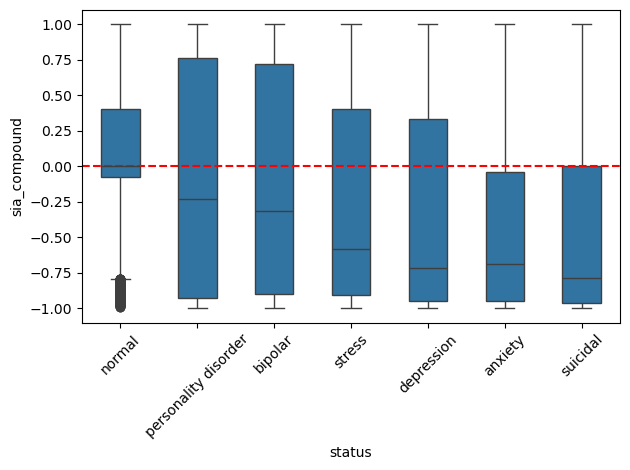

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Visualize most positive means to most negative means
sns.boxplot(data=df,
            x='status',
            y='sia_compound',
            vert=True,
            order=df.groupby('status')['sia_compound'].mean().sort_values(ascending=False).index,
            width=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Note: sia_compound is a score that represents a holistic picture of whether a statement is negative (-), neutral (0), or positive (+).

Observations:
- Normal is the only class with a mean that isn't negative.
- Stress, bipolar, depression, and personality disorder all have negative means but wide standard deviations (IQRs)
- Anxiety and Suicidal are all negative but have smaller standard deviations (IQRs)

One can imagine a simple decision tree model that can learn these subtleties.

Also, the means give us a picture of how Sentiment Analysis models classify how "negative" each class is.

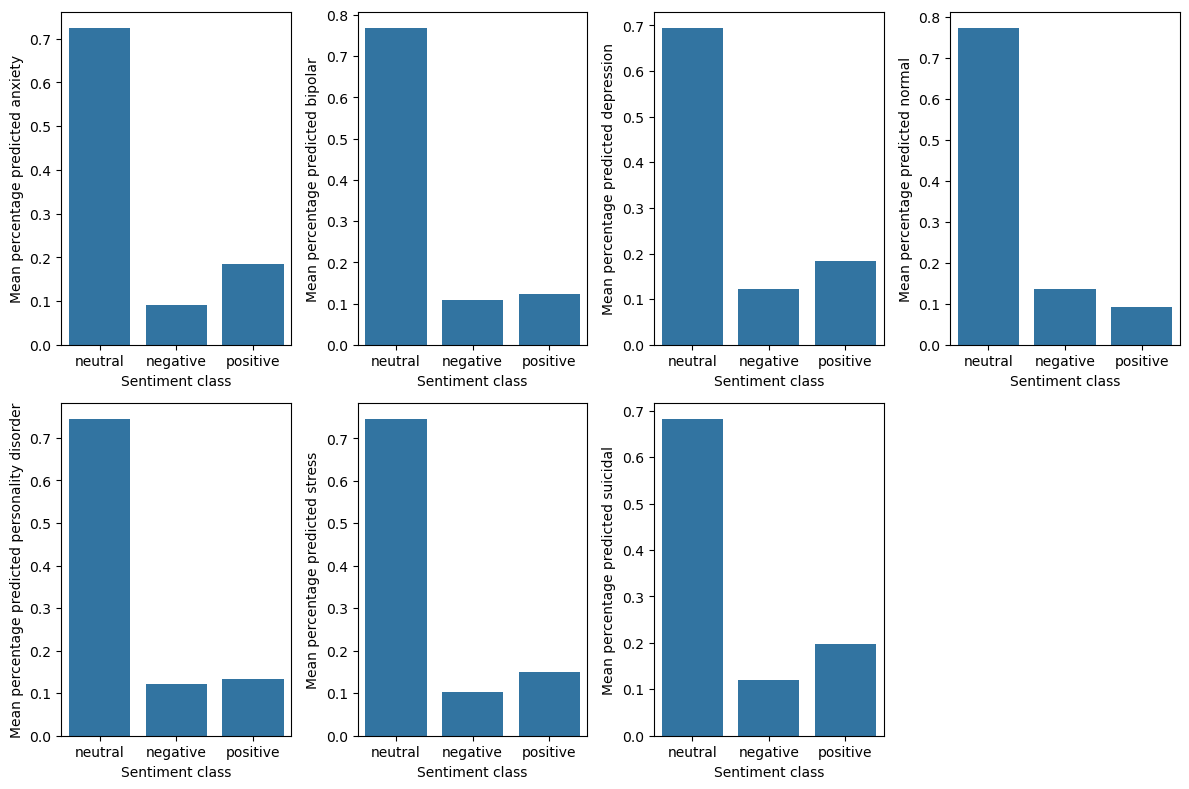

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Plot mean sentiment scores per class
plt.figure(figsize=(12, 8))
for i, (status, group_df) in enumerate(list(df.groupby('status')), 1):

    # Calculate stuff (I'm borrowing code from lec1-outlier.ipynb)
    sentiment_dict = {'neutral': group_df['sia_neu'].mean(),
                      'negative': group_df['sia_pos'].mean(),
                      'positive': group_df['sia_neg'].mean()}
    plt.subplot(2, 4, i)
    sns.barplot(sentiment_dict)
    plt.ylabel(f'Mean percentage predicted {status}')
    plt.xlabel('Sentiment class')

plt.tight_layout()
plt.show()

Plotting the mean predicted percentage of each sentiment does not show us any interesting results.

Conclusions:
- From this we see that the `normal` class's sentiments behave unlike the other classes.
- We also see that this pretrained model almost sees the remaining mental health status in terms of a regression: how "negative" a class is.
- We can treat this dataset as a double objective:
  - First predict whether a text is `normal` or a cummulative class called `flagged` (Binary Classification)
  - If the text was predicted `flagged`, we then further predict for the other **potential** statuses: `anxiety`, `bipolar`, `depression`, `personality disorder`, `stress`, or `suicidal` (Multiclass Classification or a Regression)

# Ngram

From 1 to n, find the distribution of sequences of those lengths.

First, let's look at overall ngrams of the full dataset.

In [16]:
import nltk
from nltk.util import ngrams
from collections import Counter


text = " ".join(df['statement'])
text_tokenized = nltk.word_tokenize(text)

# NOTE: Choice of N is exactly relevant to the bias-variance tradeoff. With more N, you capture more contextual patterns in the dataset (lowers bias). However, the longer and longer the phrases get, the more infrequent they become (increases variance).
# For computational reasons such as memory constraints, 5 is usually a good number, though the size of the dataset BEFORE class balancing can allow for larger contexts being used.
# If we decide to balance classes, 5 is the most we should do!

n = 5
ngram_list = {}
for i in range(1, n+1):
  ngram_list[i] = Counter(ngrams(text_tokenized, i))

ngram_list

{1: Counter({('i',): 401486,
          ('to',): 197461,
          ('and',): 175484,
          ('the',): 126760,
          ('my',): 119450,
          ('a',): 117741,
          ('not',): 91682,
          ('it',): 86313,
          ('of',): 84899,
          ('me',): 72314,
          ('is',): 72226,
          ('have',): 69897,
          ('that',): 67990,
          ('am',): 62457,
          ('in',): 61803,
          ('but',): 56382,
          ('do',): 55788,
          ('for',): 54544,
          ('just',): 48823,
          ('this',): 47272,
          ('so',): 43495,
          ('with',): 41588,
          ('like',): 38271,
          ('was',): 37809,
          ('be',): 34977,
          ('can',): 34500,
          ('on',): 31651,
          ('feel',): 31595,
          ('you',): 31564,
          ('or',): 28012,
          ('want',): 27294,
          ('all',): 26220,
          ('about',): 25426,
          ('at',): 24042,
          ('if',): 23930,
          ('know',): 23542,
          ('what',): 22679,

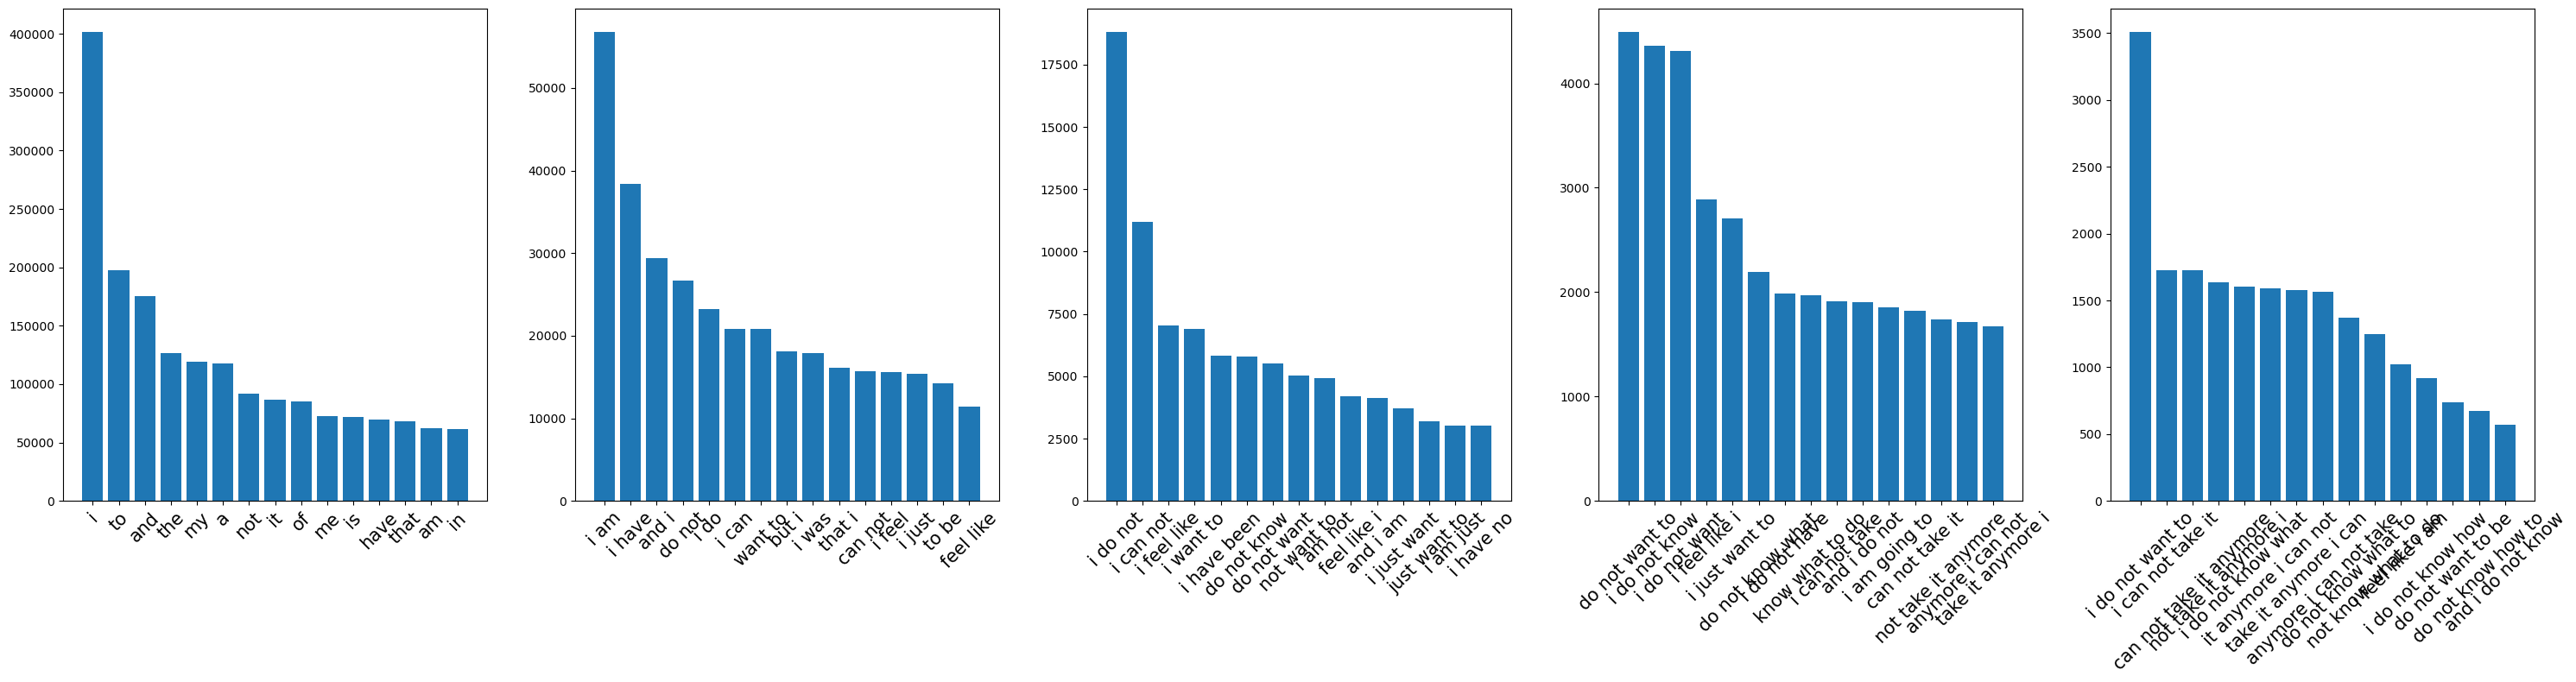

In [17]:
import matplotlib.pyplot as plt

top_n = 15

plt.figure(figsize=(30,8))

for ngram in ngram_list:
  grams = ngram_list[ngram].most_common(top_n)
  labels = [' '.join(gram[0]) for gram in grams]
  frequencies = [gram[1] for gram in grams]
  plt.subplot(1, n, ngram)
  plt.bar(range(len(labels)), frequencies)
  plt.xticks(range(len(labels)), labels, rotation=45, fontsize=15)

plt.tight_layout()
plt.show()

Looking at the overall distribtions of the ngrams, we can see there are certain phrases that are exponentially larger in this whole dataset. Given this, let's now look at the ngrams for each status.

In [18]:
status2ngram = {}
for status, group_df in df.groupby('status'):
  curr_ngram = {}
  text_tokenized = nltk.word_tokenize(" ".join(group_df['statement']))
  for i in range(1, n+1):
    curr_ngram[i] = Counter(ngrams(text_tokenized, i))
  status2ngram[status] = curr_ngram

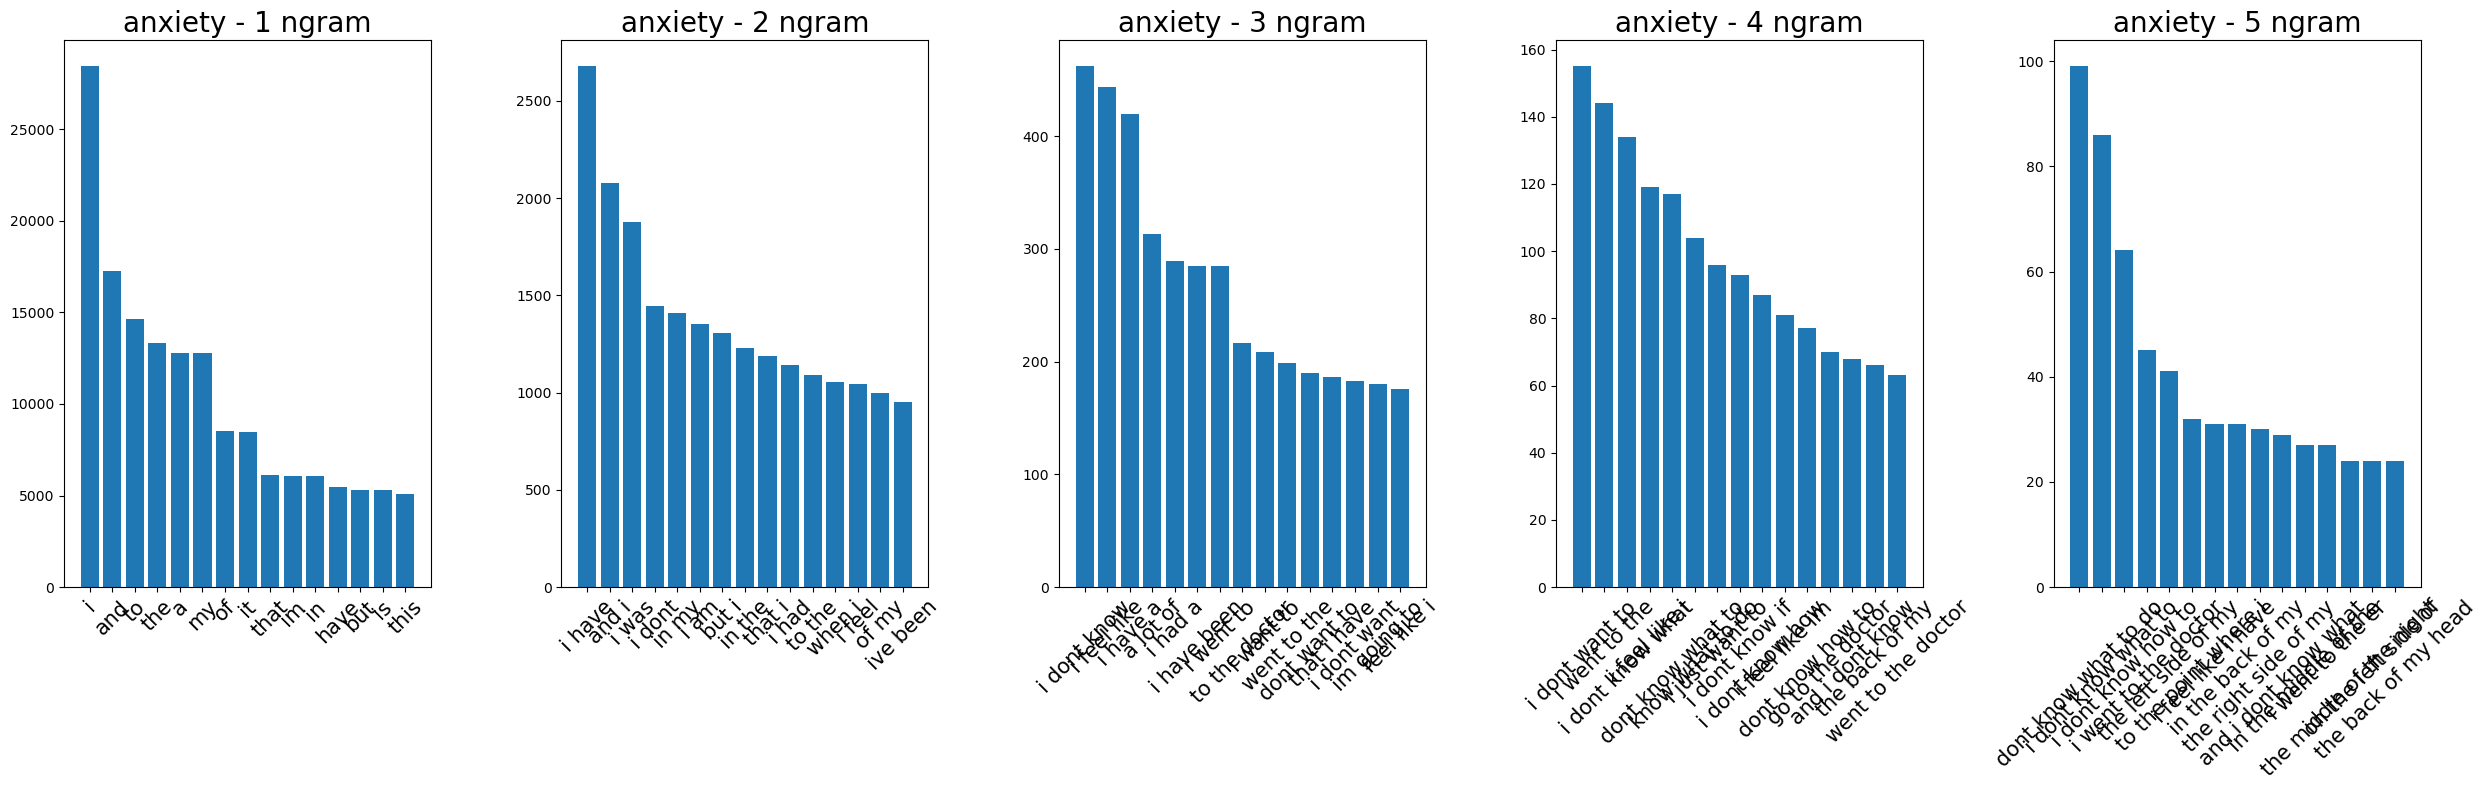

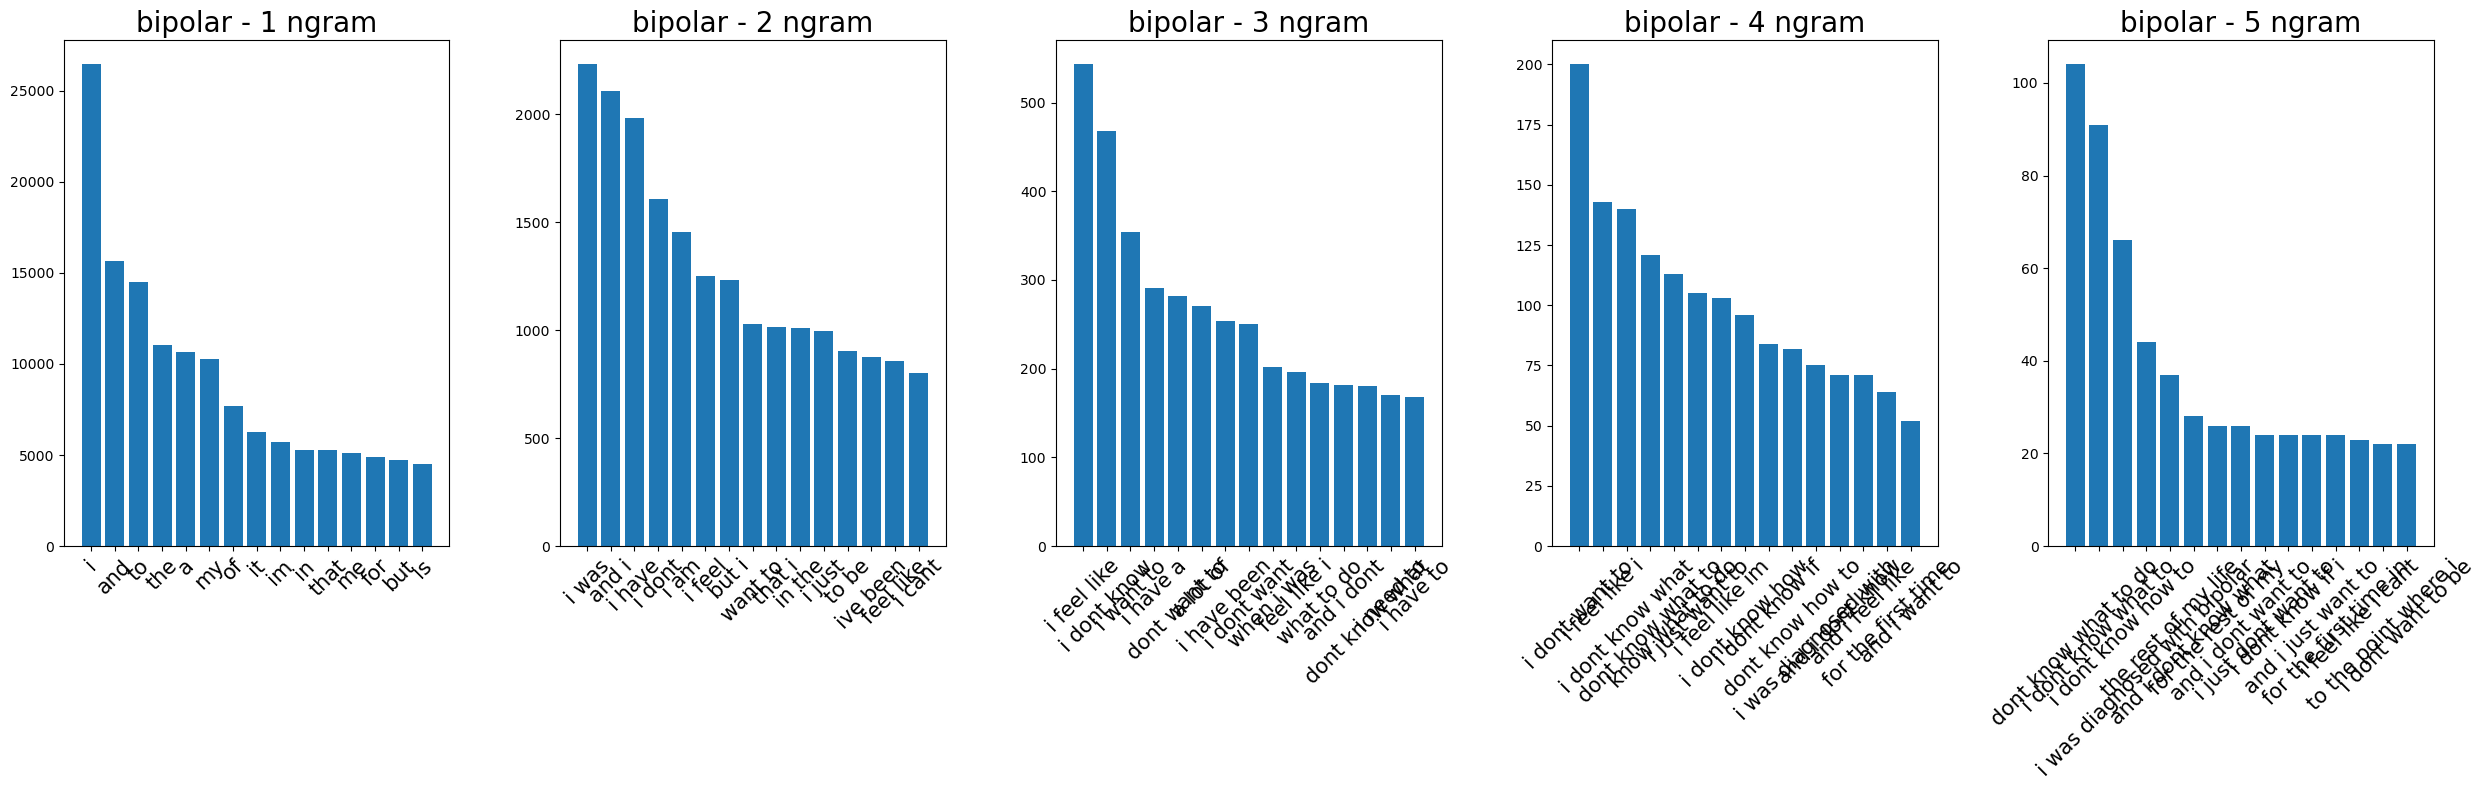

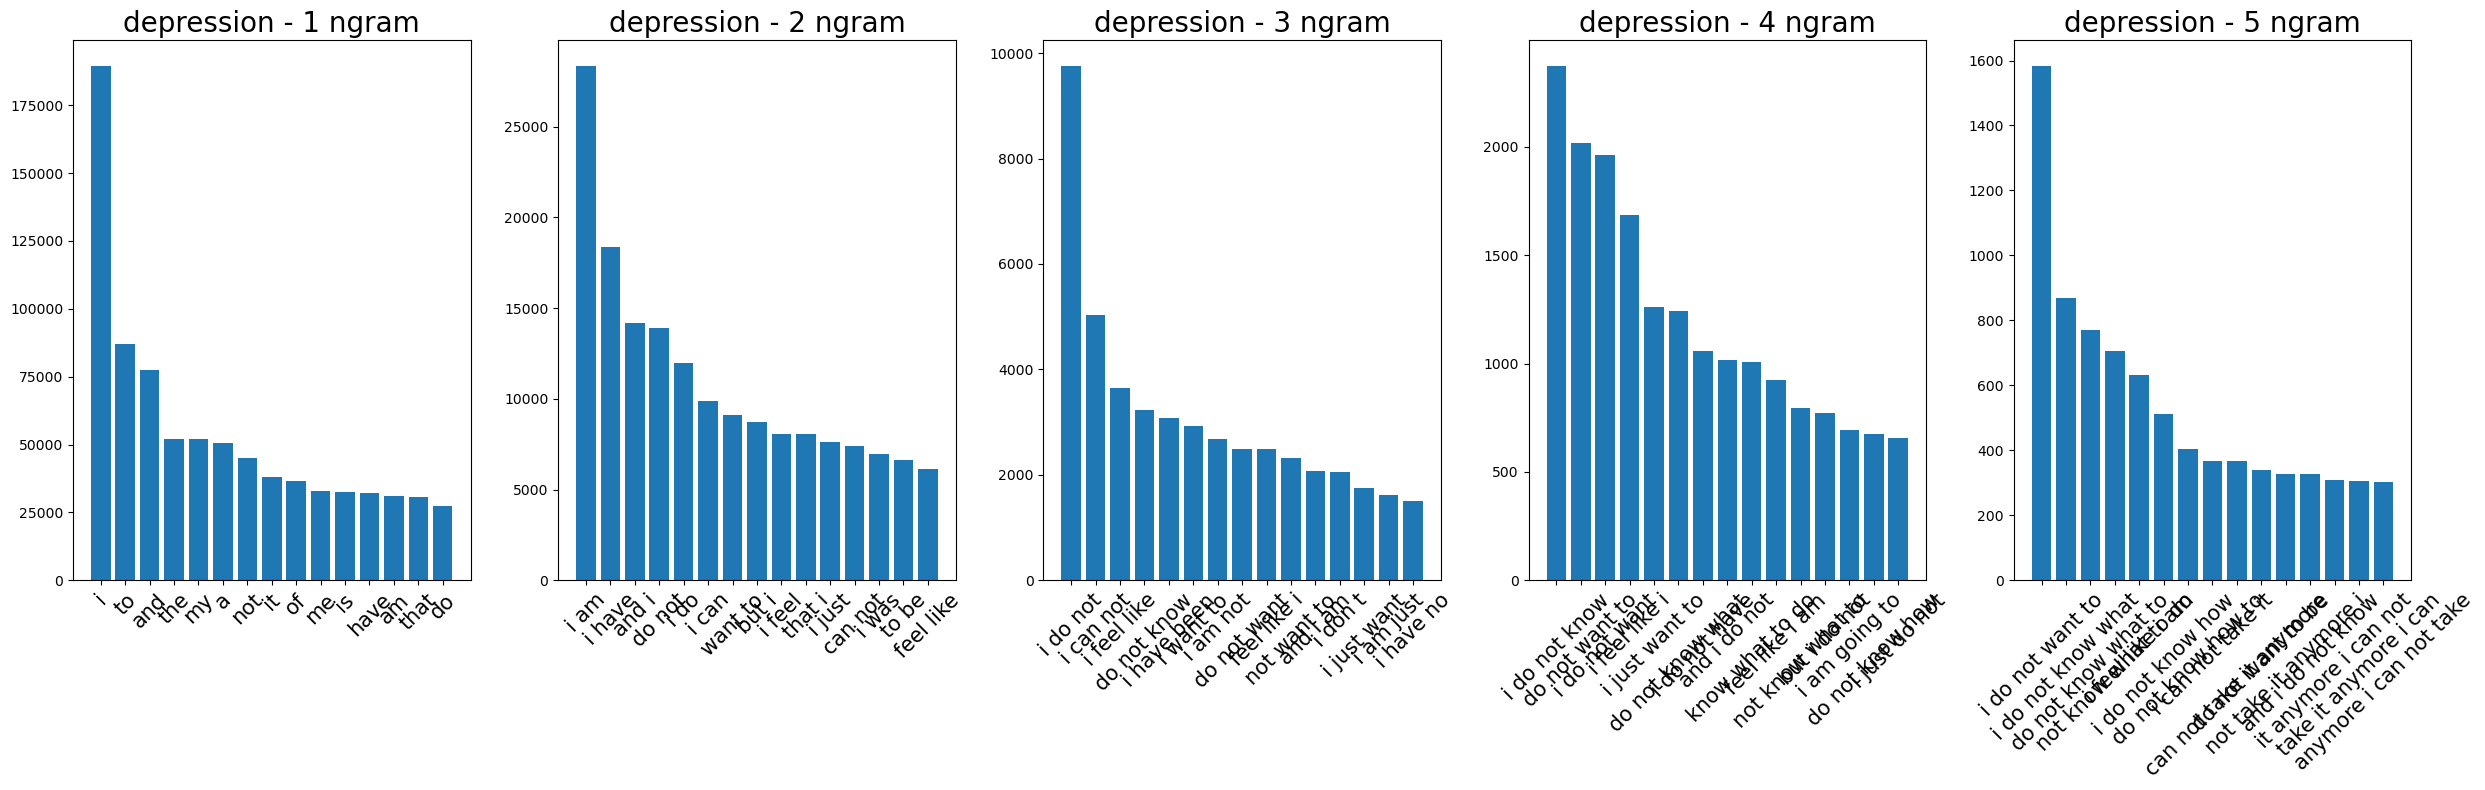

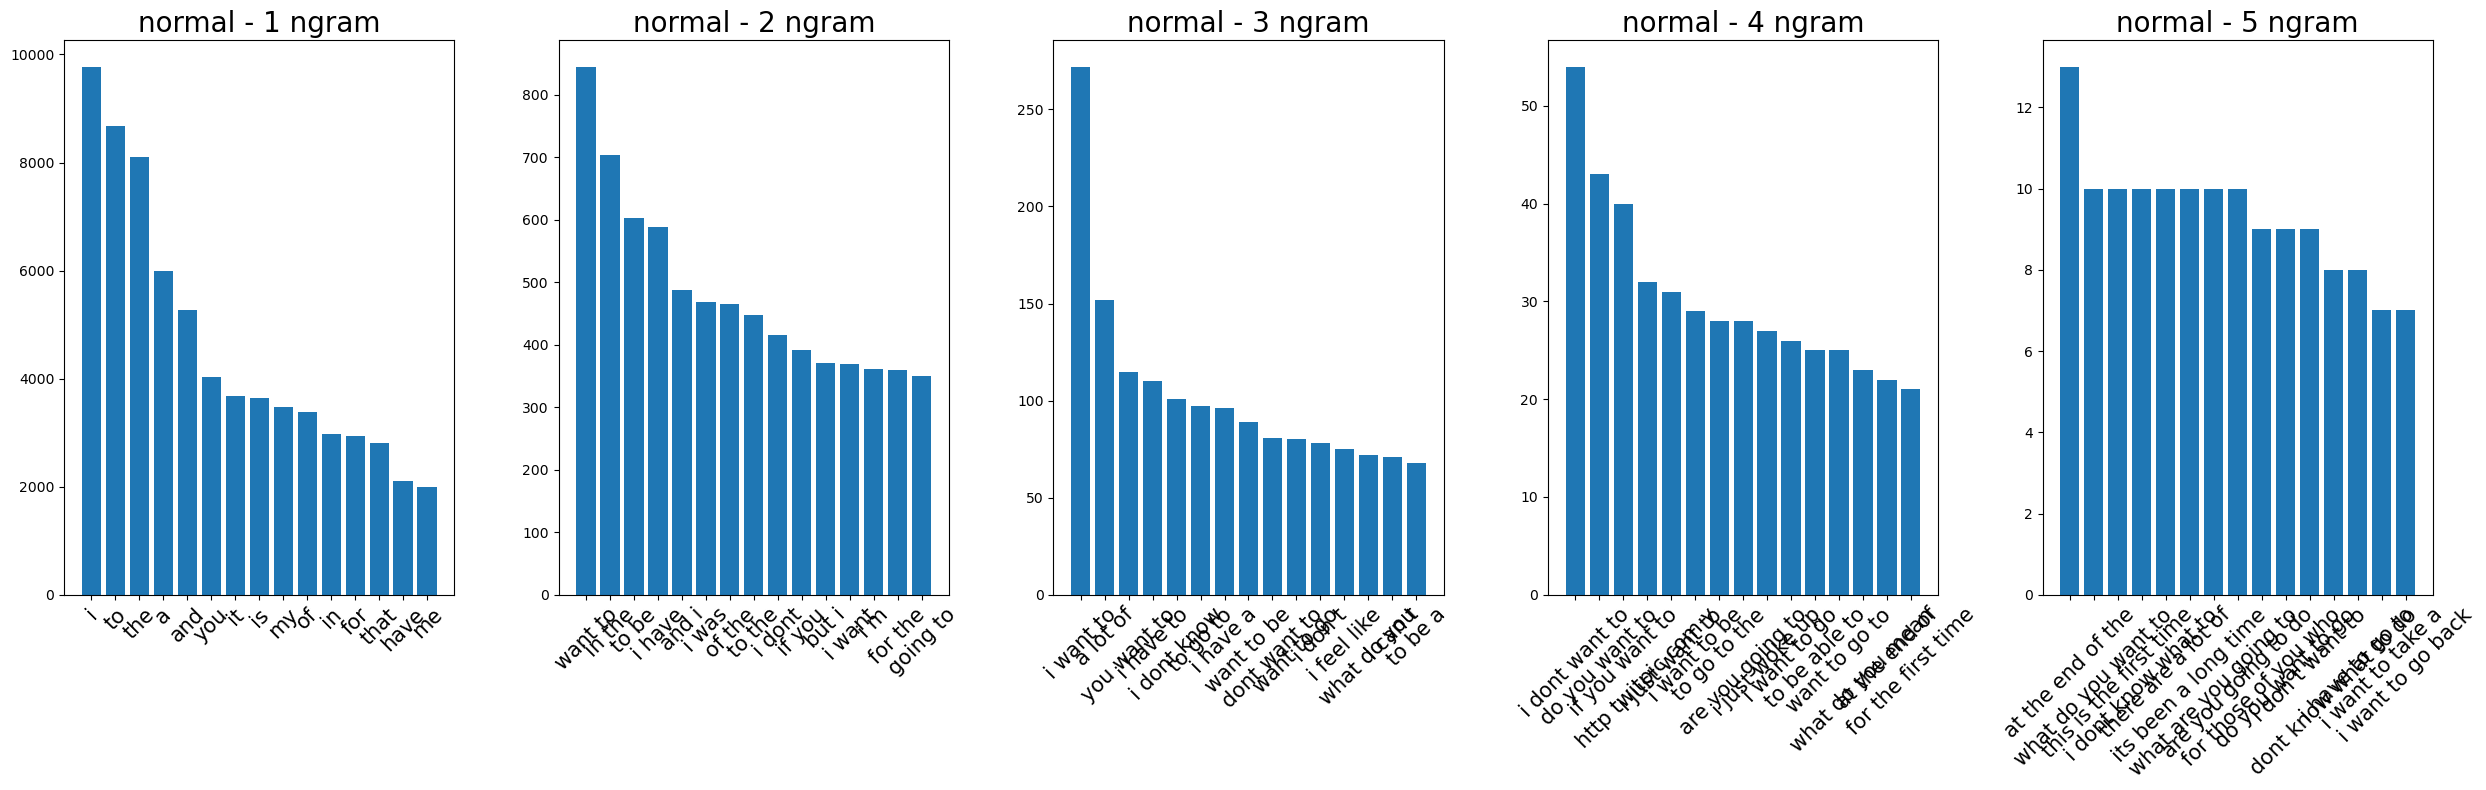

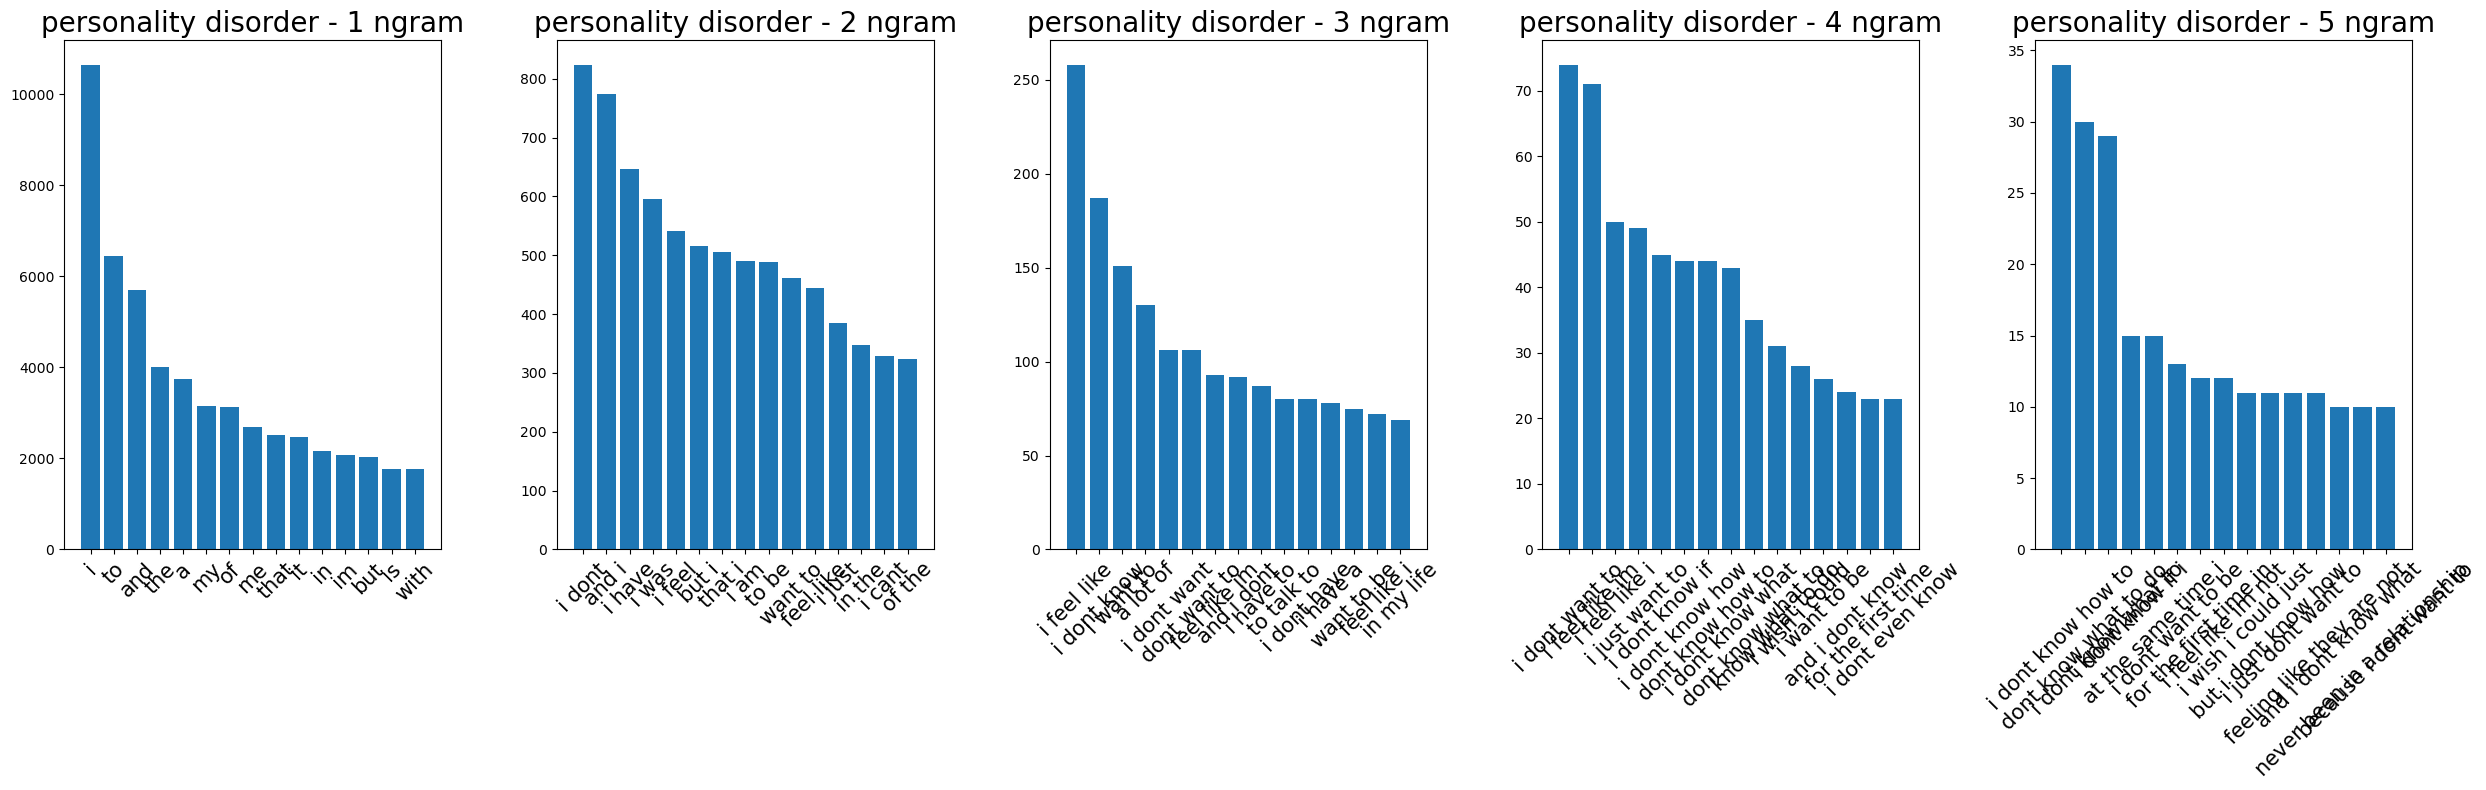

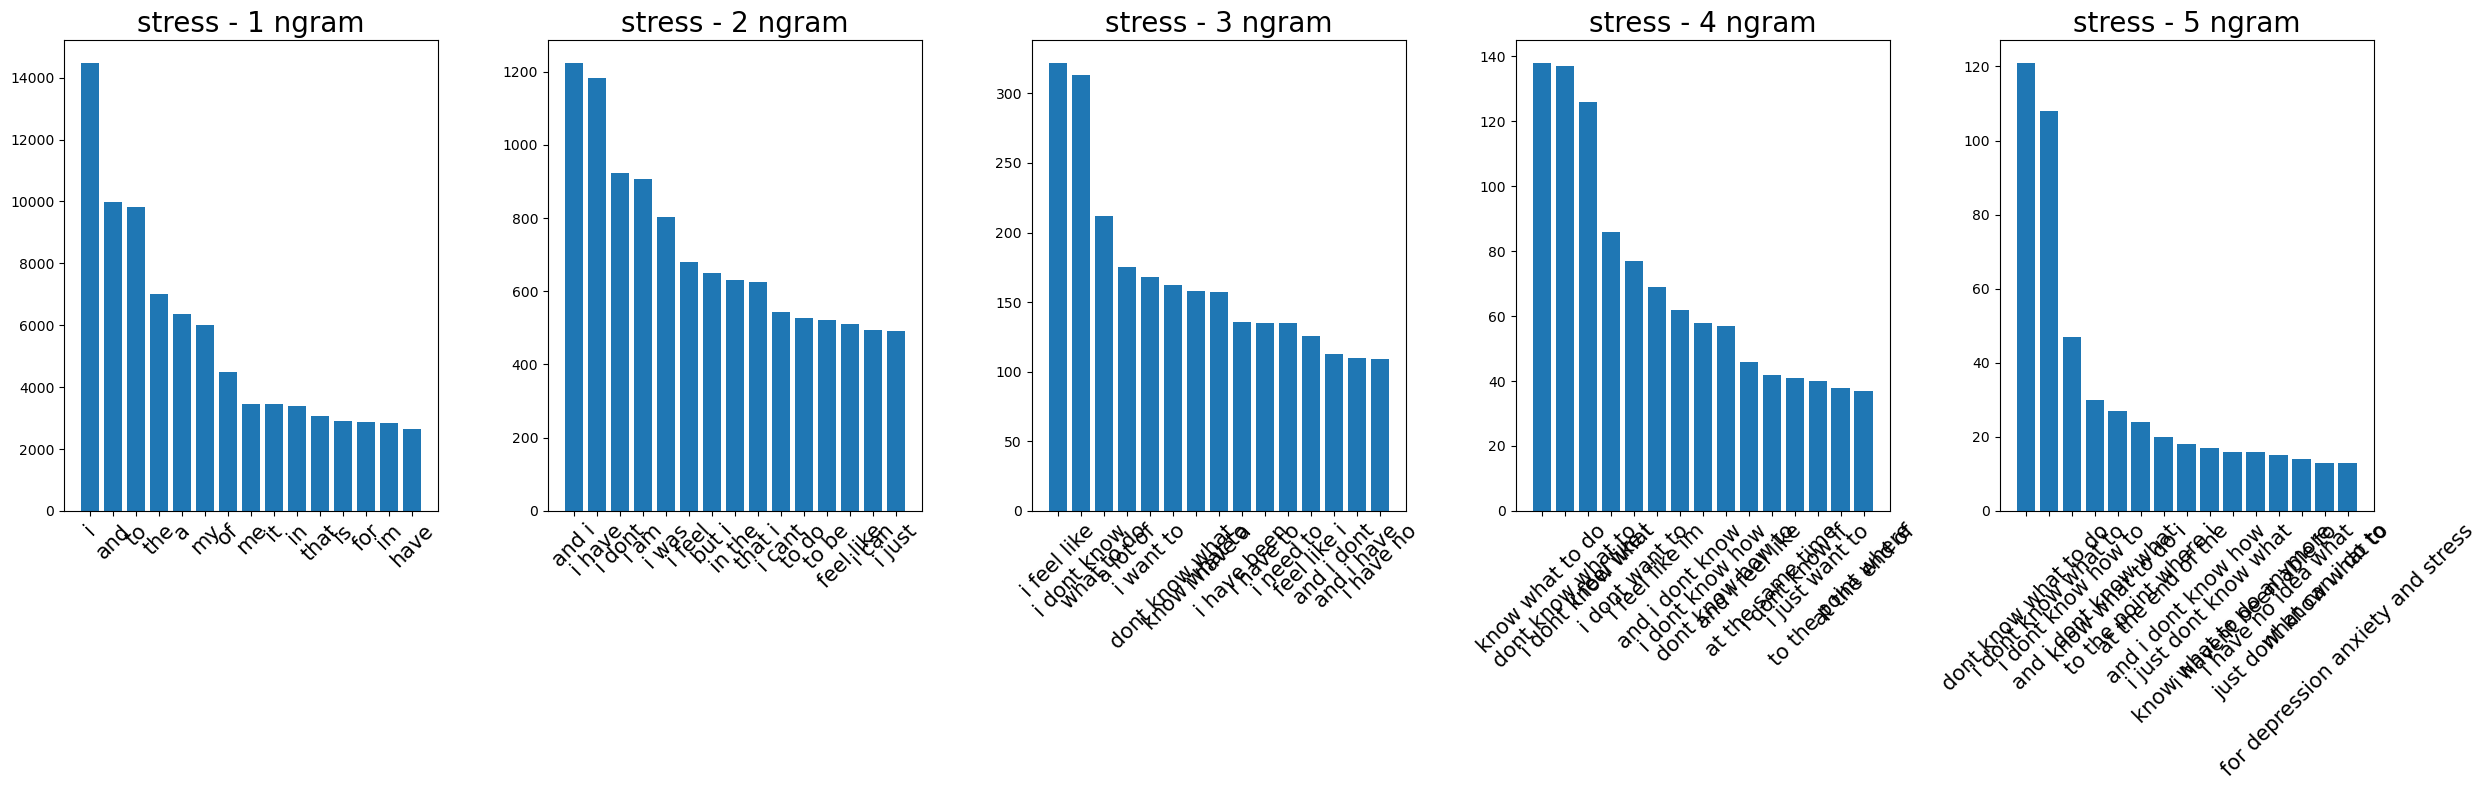

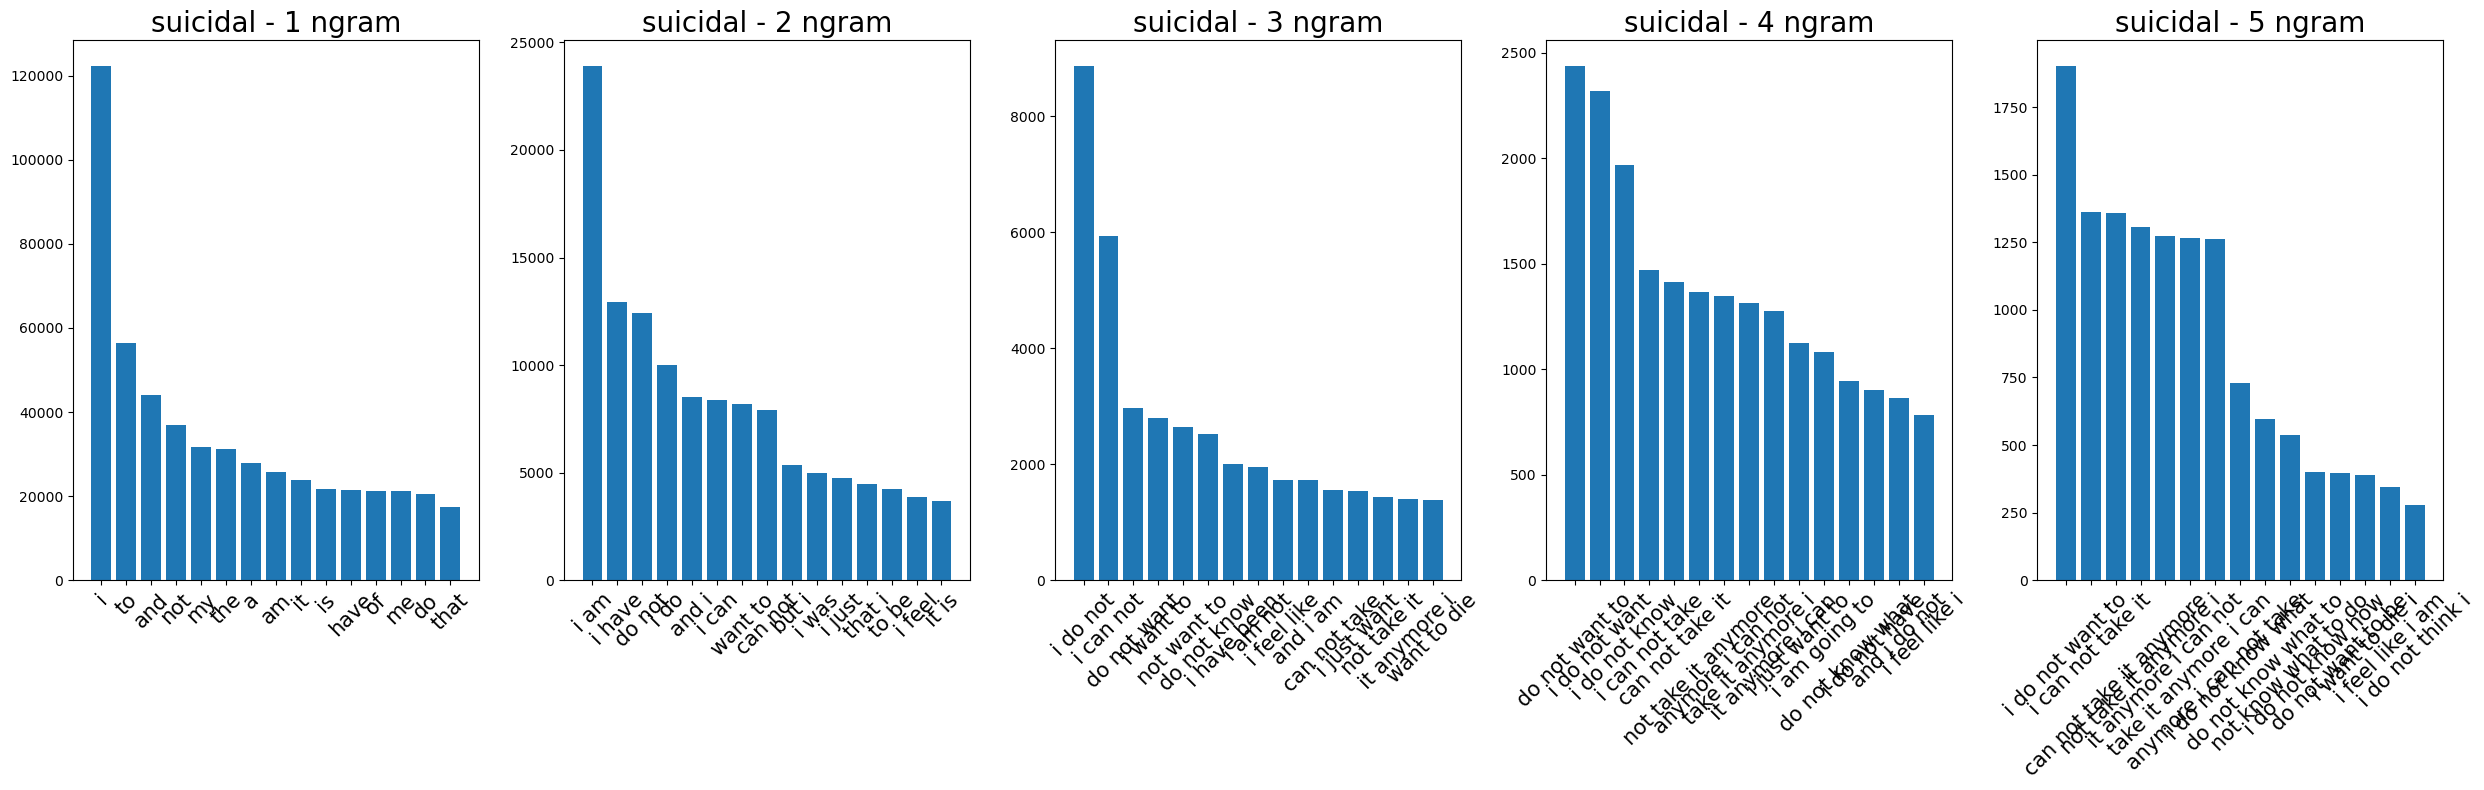

In [19]:
import matplotlib.pyplot as plt

top_n = 15


num_plots = sum(len(ngram_dict) for ngram_dict in status2ngram.values())

for index, status in enumerate(status2ngram):
  curr_ngram_list = status2ngram[status]
  idx = 1
  plt.figure(figsize=(25,8))
  for ngram in curr_ngram_list:
    grams = curr_ngram_list[ngram].most_common(top_n)
    labels = [' '.join(gram[0]) for gram in grams]
    frequencies = [gram[1] for gram in grams]
    plt.subplot(1, n, idx)
    plt.bar(range(len(labels)), frequencies)
    plt.xticks(range(len(labels)), labels, rotation=45, fontsize=15)
    plt.title(f'{status} - {ngram} ngram', fontsize=20)
    idx += 1

  plt.tight_layout()
  plt.show()

Clearly, there are certain phrases that are special to each status. The first ngram of length 1 doesn't give us much contextual information, as it only tells us word distributions which closely resemble that of the whole dataset. Even the 2nd ngram, while it does show some variance across all statuses, doesn't hold enough contextual information to make any judgements. The 3rd-5th degree ngram certainly do hold phrases that are *special* to each status.

The distribution of the phrases is expected, as Zipf's law states that the frequency of a phrase is inversely proportional to its rank on the table. In this case, only the top 1-3 phrases are only truly very frequent in each status ngram. 

Here they are:

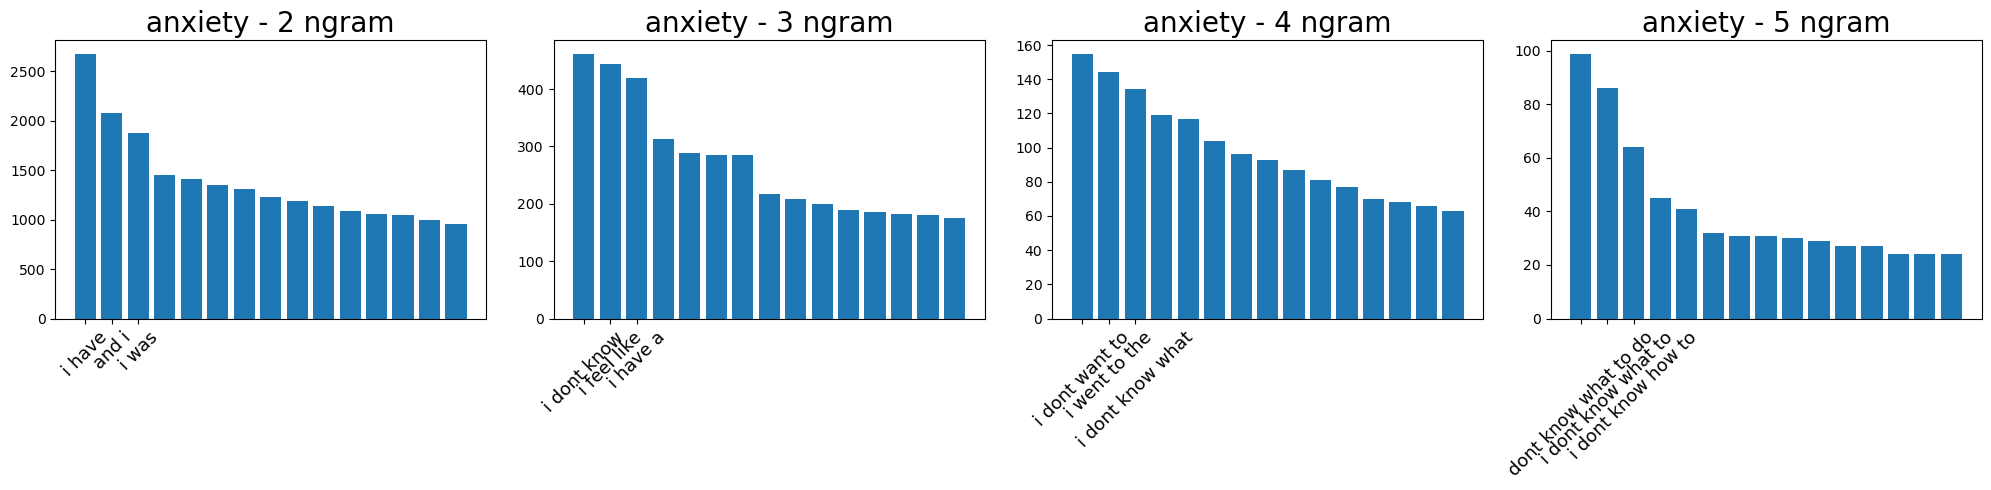

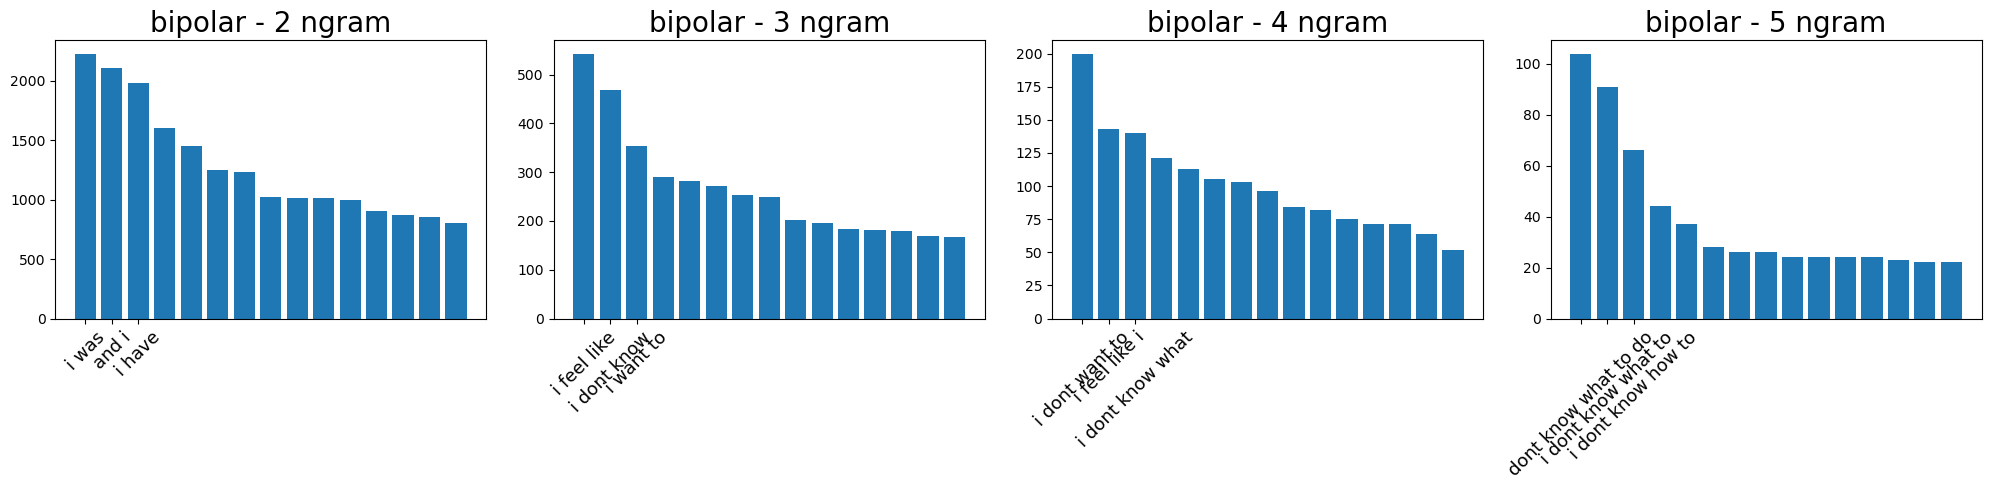

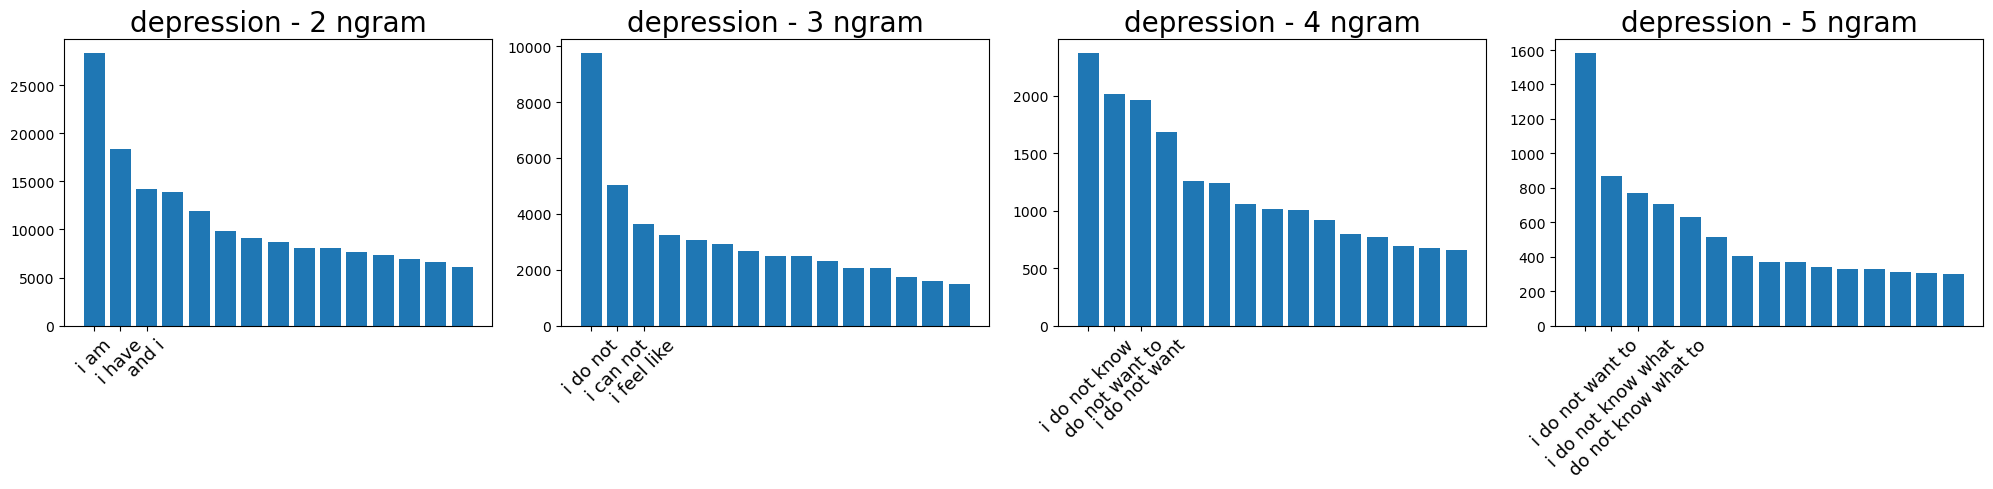

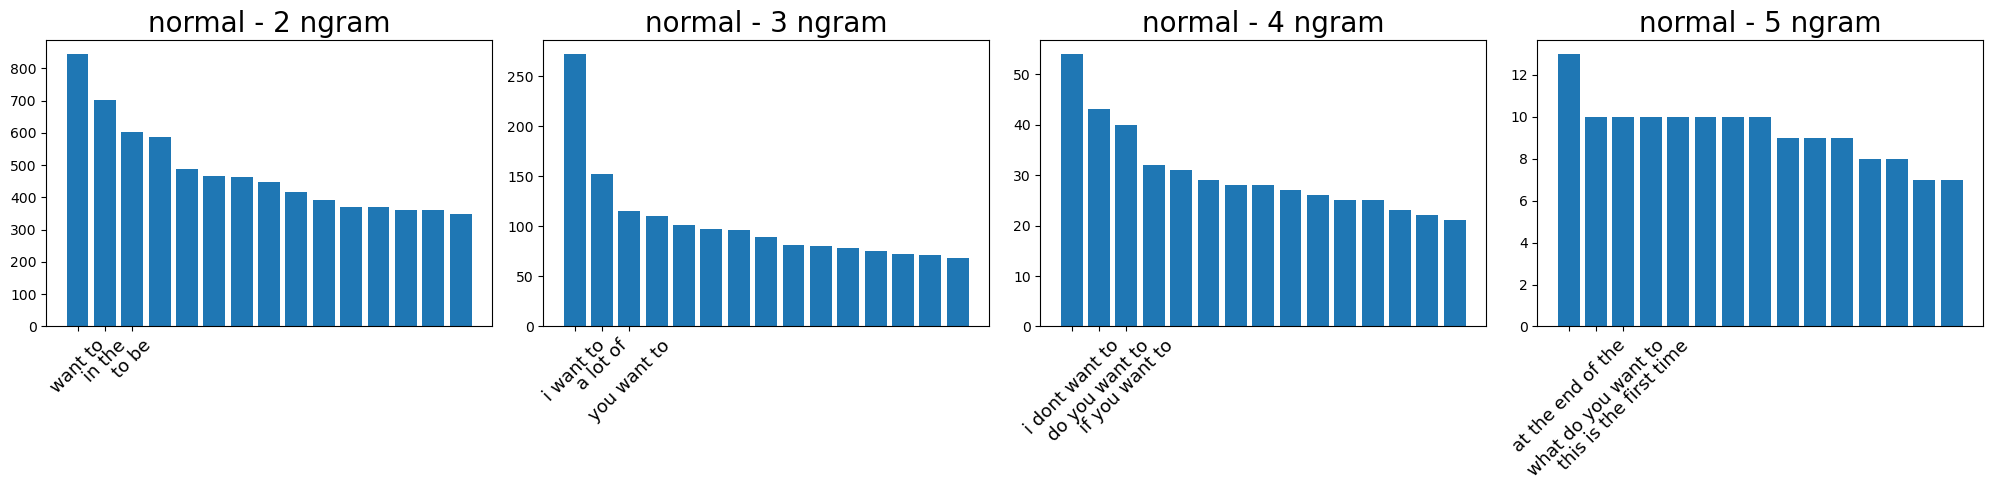

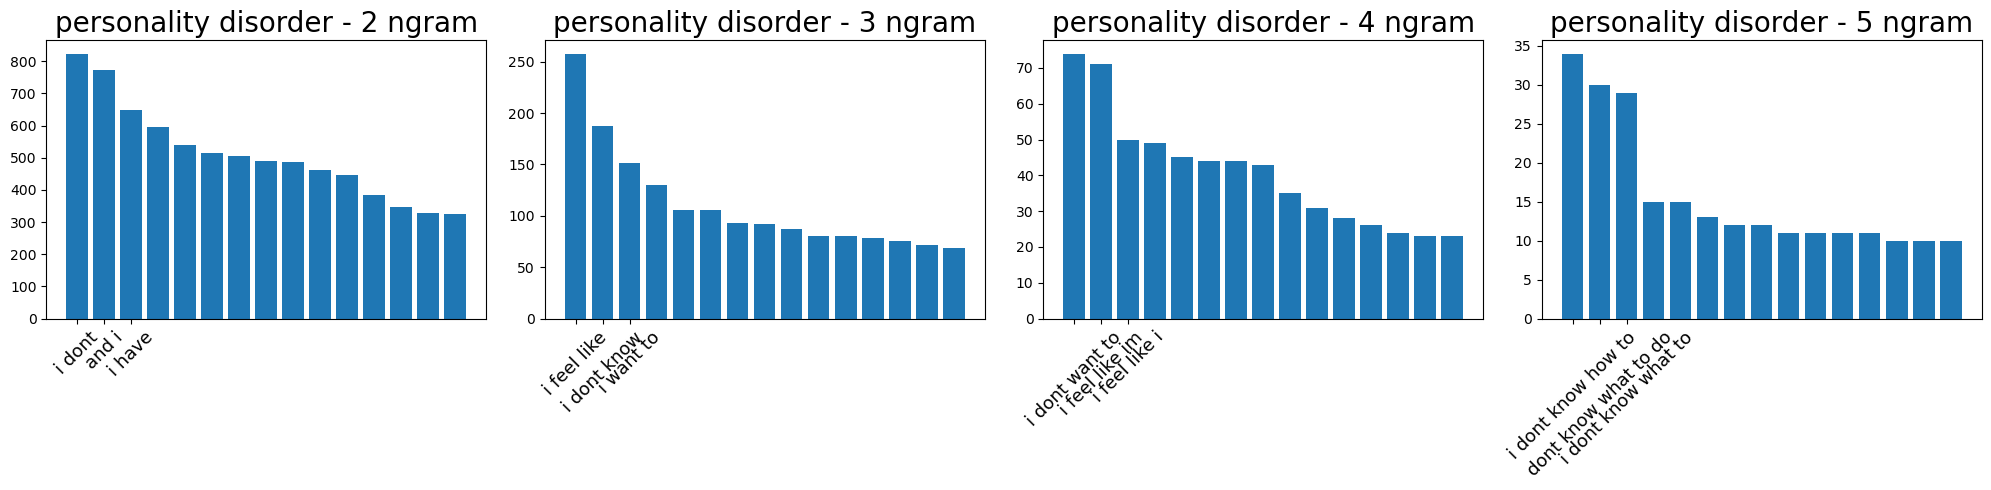

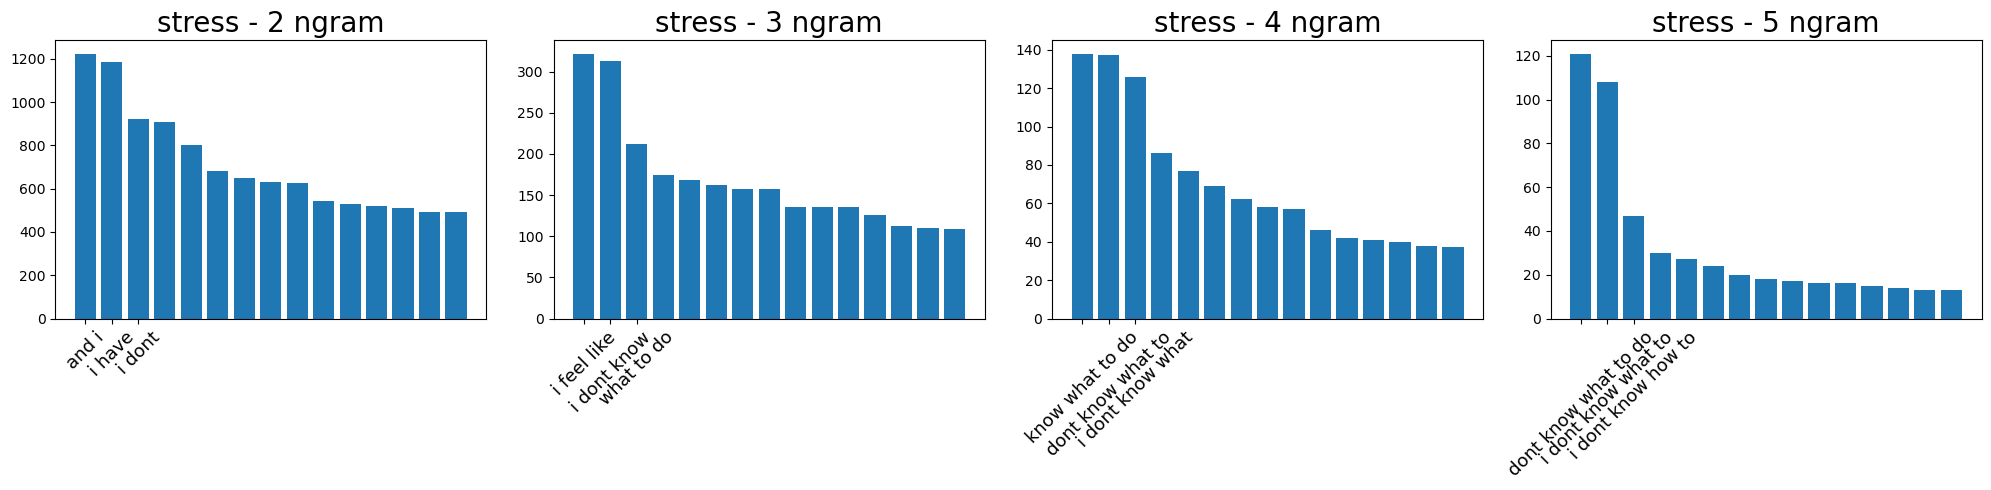

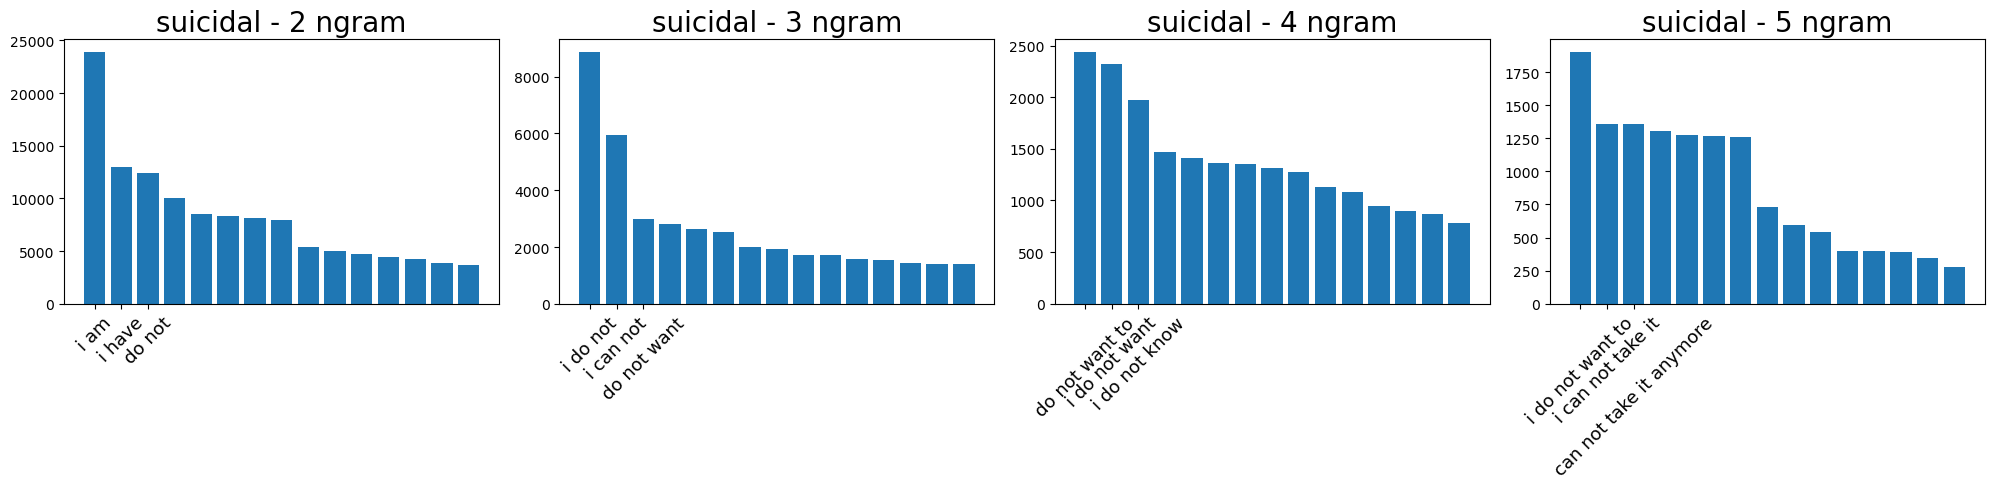

In [20]:
import matplotlib.pyplot as plt

top_n = 15
top_top_n = 3


num_plots = sum(len(ngram_dict) for ngram_dict in status2ngram.values())

for index, status in enumerate(status2ngram):
  curr_ngram_list = status2ngram[status]
  idx = 1
  plt.figure(figsize=(25,5))
  for ngram in range(2,5+1):
    grams = curr_ngram_list[ngram].most_common(top_n)
    labels = [' '.join(gram[0]) for gram in grams]
    frequencies = [gram[1] for gram in grams]
    plt.subplot(1, n, idx)
    plt.bar(range(len(labels)), frequencies)
    plt.xticks(range(top_top_n), labels[:top_top_n], rotation=45, fontsize=13)
    plt.title(f'{status} - {ngram} ngram', fontsize=20)
    idx += 1
  plt.tight_layout()
  plt.show()

While there definitely are overlap in phrases still in the 5grams, certain phrases are more unique to each class. For example, Anxiety, Suicidal, Bipolar, Stress, Personality Disorder, and Depression all have similar 5grams in terms of their contents, but their rankings of which phrase is more frequent may differ. Furthermore, even more variance in which phrases are more frequent is shown in the lower-rank ngrams. 

If ngram is used as a feature, it will have to be used with the intent of "maximizing variance" among the ngrams. That is, at the surface the top few most frequent phrases won't say much about the status, but capturing the full distribution of phrases will say more. 

# Latent Semantic Analysis

This is an approach to discover hidden "latent" meaning in text by looking beyond just phrase frequencies. It does this by creating a document-term matrix and then shrinking that matrix down using SVD, keeping the Top_k dimensions. The result is a semantic vector space where words & documents that occur in more similar contexts will appear next to each other.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the document x term frequency matrix
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(df['statement']) # 6 seconds

In [ ]:
bag_of_words.todense() # 40 seconds

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(52681, 78064))

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Select top 7 components (i.e. a component for each status)
svd = TruncatedSVD(n_components=len(df['status'].value_counts()))
lsa = svd.fit_transform(bag_of_words)

In [ ]:
import pandas as pd

# Put everything into 1 dataframe
topic_encoded_df = pd.DataFrame(lsa, columns=[f'topic_{i}' for i in range(len(df['status'].value_counts()))])
topic_encoded_df['statement'] = df['statement']
topic_encoded_df['status'] = df['status']
topic_encoded_df

topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
0       0.266943 -0.075057 -0.104725 -0.431098 -0.377488  0.156624 -0.471145   
1       0.309099 -0.085264 -0.144359  0.196252 -0.232123 -0.077780 -0.063610   
2       0.647474 -0.180985 -0.417596 -0.238294 -0.227499 -0.262043  0.518118   
3       0.904759 -0.250554  0.017246 -0.362184 -0.304935  1.020988 -0.189268   
4       0.763208 -0.209610  0.002210 -0.030734 -0.150037 -0.332072  1.010793   
...          ...       ...       ...       ...       ...       ...       ...   
52676  21.194916 -4.834583 -2.871045 -5.207751 -0.575564  6.090227  0.877567   
52677  12.173405 -2.837225 -2.020631 -0.140840 -2.426610  0.952025 -0.632078   
52678   1.193253 -0.327353 -0.047148  1.052987 -0.182991  0.353824 -0.155628   
52679   5.488497 -0.994987 -0.569694  1.922646 -0.485106  2.251555  0.401179   
52680   5.305532 -0.936574 -0.857420  2.320453 -1.476727  0.052414  0.961986   

                                               statement   status  
0                                             oh my gosh  anxiety  
1      trouble sleeping confused mind restless heart ...  anxiety  
2      all wrong back off dear forward doubt stay in ...  anxiety  
3      ive shifted my focus to something else but im ...  anxiety  
4      im restless and restless its been a month now ...  anxiety  
...                                                  ...      ...  
52676  nobody takes me seriously ive 24m dealt with d...  anxiety  
52677  selfishness i dont feel very good its like i d...  anxiety  
52678  is there any way to sleep better i cant sleep ...  anxiety  
52679  public speaking tips hi all i have to give a p...  anxiety  
52680  i have really bad door anxiety its not about b...  anxiety  

[52681 rows x 9 columns]

We can also look at the encoding matrix. This will show us the words corresponding to each topic.

In [ ]:
encoding_matrix = pd.DataFrame(svd.components_,
                               index=[f'topic_{i}' for i in range(len(df['status'].value_counts()))],
                               columns=list(vectorizer.vocabulary_.keys())).T
encoding_matrix

topic_0       topic_1       topic_2       topic_3  \
oh              1.733937e-04 -4.640466e-05 -3.591092e-04  2.364554e-04   
my              5.889510e-05 -1.526448e-05 -1.875311e-04 -1.609387e-04   
gosh            8.826960e-08 -4.533577e-08 -3.306966e-07 -2.232195e-07   
trouble         5.448490e-06 -1.736027e-06 -1.182905e-05 -5.306318e-05   
sleeping        2.235330e-07 -1.145765e-07 -2.703129e-06 -3.283895e-06   
...                      ...           ...           ...           ...   
coprophobia     1.029527e-05 -3.981611e-06 -7.652586e-05  5.539757e-05   
strokelike      9.662804e-07 -1.694837e-07 -1.689963e-06 -1.984440e-06   
attacklike      6.637047e-07 -3.378078e-07  5.012104e-07 -2.665536e-06   
tingeling       3.028362e-07 -1.534021e-07  9.789824e-07  1.181724e-06   
fatherdaughter  9.129463e-09 -4.241522e-09  6.336623e-07 -3.016065e-08   

                     topic_4       topic_5       topic_6  
oh             -2.238462e-04  4.582718e-04  4.967082e-04  
my              1.818946e-04  2.316510e-04  3.278360e-04  
gosh            6.805528e-08  1.648000e-06  2.492254e-06  
trouble         2.177414e-05  2.667492e-05 -1.643557e-05  
sleeping        1.166224e-06 -4.031086e-06  3.375703e-06  
...                      ...           ...           ...  
coprophobia    -9.177791e-05  4.388275e-05 -3.985544e-05  
strokelike      6.577881e-07  1.240223e-05 -3.487905e-06  
attacklike      4.019444e-06  4.731690e-06 -1.403750e-06  
tingeling      -1.309812e-06  4.424638e-06 -3.049148e-06  
fatherdaughter  1.234184e-07 -4.469978e-07 -7.647719e-08  

[78064 rows x 7 columns]

In [ ]:
import numpy as np

for topic in encoding_matrix:
  encoding_matrix[f'abs_{topic}'] = np.abs(encoding_matrix[topic])

We can look at the top words used in each topic.

In [ ]:
for i in range(1, 7):
  print(encoding_matrix[[f'abs_topic_{i}']].sort_values(f'abs_topic_{i}', ascending=False).head(10))

              abs_topic_1
jinyounggggg     0.491397
findest          0.491217
massive          0.489319
servery          0.456764
springsteen      0.118078
ahiri            0.111722
mangaaa          0.080349
quickly2020      0.074707
mmorpg           0.053033
thrs             0.045840
             abs_topic_2
amado           0.390281
common          0.360296
steadily        0.336343
mangaaa         0.321707
ahiri           0.291145
presurvey       0.237165
springsteen     0.231787
myopia          0.167321
xrayed          0.166424
ambush          0.164936
             abs_topic_3
mangaaa         0.521769
quickly2020     0.432466
essaysthese     0.378577
ahiri           0.345772
thrs            0.194719
mmorpg          0.193537
springsteen     0.145649
20210718        0.136649
meclizine       0.119050
nmue            0.117727
             abs_topic_4
myopia          0.530110
gona            0.386789
quickly2020     0.377571
thrs            0.239074
springsteen     0.237615
presurvey     

A lot of the most "informative" words are content words. This might suggest LSA is the wrong technique for quantifying mental health as these are showing actual text topic rather than text sentiment.

Still, let's look at if the topics correspond to statuses

/tmp/ipykernel_535135/4261392380.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(topic_1, topic_2, alpha=0.5, c=color_wheel[i % len(color_wheel)], label=status)
/tmp/ipykernel_535135/4261392380.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(topic_1, topic_2, alpha=0.5, c=color_wheel[i % len(color_wheel)], label=status)
/tmp/ipykernel_535135/4261392380.py:21: UserWarning: *

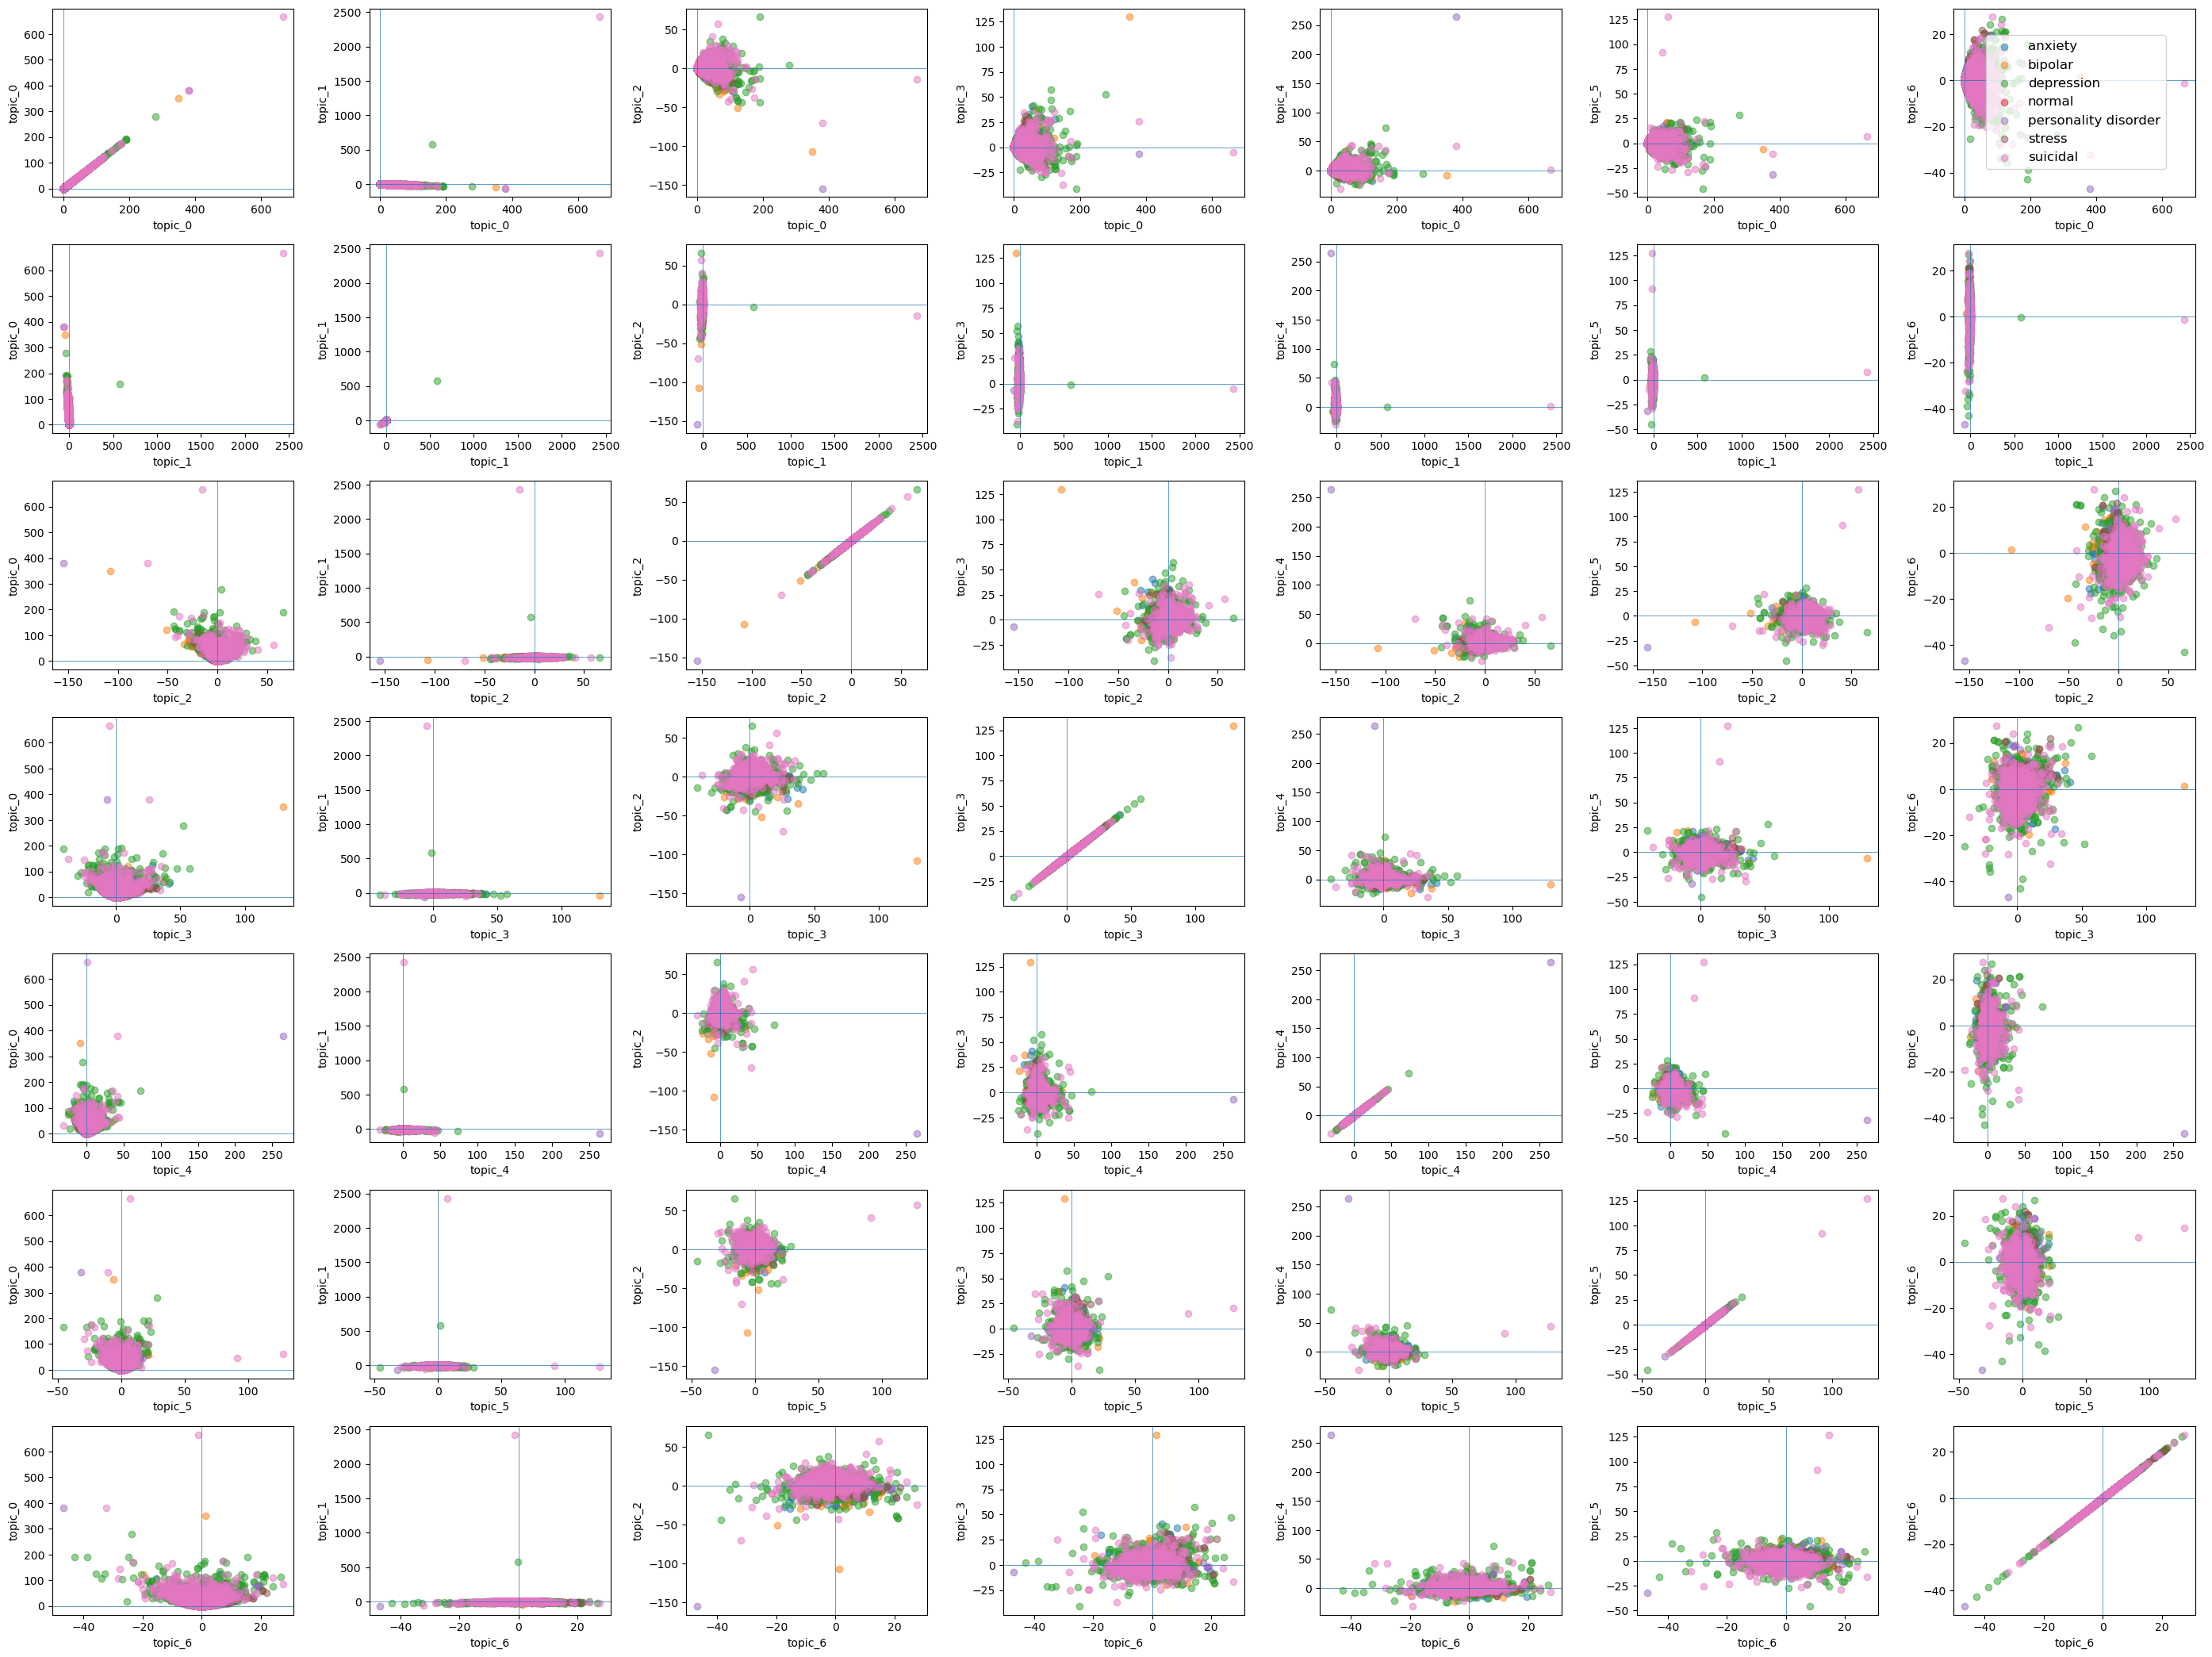

In [ ]:
import matplotlib.pyplot as plt # Runtime: 1.5 minutes

topics = [f'topic_{i}' for i in range(7)]
color_wheel = plt.cm.tab10.colors

fig, ax = plt.subplots(len(topics), len(topics), figsize=(len(topics) * 4, len(topics) * 3))
axes = ax.flatten()

idx = 0
handles = []
labels = []

for topic_index1 in topics:
    for topic_index2 in topics:

      ax = axes[idx]

      for i, (status, group_df) in enumerate(topic_encoded_df.groupby('status')):
        topic_1 = group_df[topic_index1].values
        topic_2 = group_df[topic_index2].values
        scatter = ax.scatter(topic_1, topic_2, alpha=0.5, c=color_wheel[i % len(color_wheel)], label=status)
        if idx == 0:
            handles.append(scatter)
            labels.append(status)
      ax.set_xlabel(topic_index1)
      ax.set_ylabel(topic_index2)
      ax.axvline(linewidth=0.5)
      ax.axhline(linewidth=0.5)
      idx += 1

fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=12, frameon=True)
plt.tight_layout()
plt.show()

This isn't a perfect visualization as there are duplicates (topic_0 x topic_1 is the same as topic_1 x topic 0), and the middle diagonal should be ignored (topic_i x topic_i). 

Based off of these plots, we're definitely going to have to do some balancing and re-run these analyses. Normal class (pink) is too noisy.

# Empath

This is an automated linguistic analyzer that does Linguistic Inquiry and Word Count (LIWDC) but is free and open source.

You can think of it as a classifier that ranks a piece of text over a set of pre-defined categories.

For the sake of this project, we can treat it as a "pre-trained model" that produces a vector embedding. Except this vector embedding is actually interpretable and has actual labels rather than just numerical values.

In [ ]:
from empath import Empath
lexicon = Empath()

In [ ]:
# Explore
index = 1
sample = df.iloc[index]['statement']
status = df.iloc[index]['status']
print(status)
print(sample)
distribution = lexicon.analyze(sample, normalize=True)
output = {}
for key in distribution.keys():
  if distribution[key] != 0.0:
    output[key] = distribution[key]
print(output)

anxiety
trouble sleeping confused mind restless heart all out of tune
{'dance': 0.1, 'sleep': 0.1, 'morning': 0.1, 'night': 0.1, 'confusion': 0.1, 'hearing': 0.1, 'music': 0.1, 'listen': 0.1, 'negative_emotion': 0.2, 'musical': 0.1}


In [ ]:
# TODO: Plot this stuff

In [ ]:
# TODO: Ariel's features

# 